# RFM用户价值分析学习目标
- 掌握RFM基本原理
- 利用RFM模型从产品、市场、财务、营销等不同方面对业务进行分析

---

# 1、什么是RFM？
概念：是衡量客户价值和客户创造利益的重要工具和手段；从三个纬度描述客户价值状况R（Recency）F（Frequency）M（monetary）

# 2、RFM各个分值对应的用户特点有哪些？
- R分值越低，说明越久没有来，流逝的可能性比较高，R分值越高活跃度比较好
- F分值越高的用户，其消费频率越高，忠诚度与LTV越高
- M分值越高，其消费金额越高顾客的价值越高

# 总结



In [2]:
# 数据加载

# 导入Pandas包
import pandas as pd

orders = pd.read_csv('./file/orders.csv')
'''
    数据条目：4384条
    存在空字段：product、orderId、gender、orderdate
    字段类型：64位浮点数、64位整型、对象类型
    占用内存：239.9KB
'''
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4384 entries, 0 to 4383
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  4384 non-null   int64  
 1   product     4382 non-null   object 
 2   orderId     4383 non-null   float64
 3   clientId    4384 non-null   int64  
 4   gender      4383 non-null   object 
 5   orderdate   4383 non-null   object 
 6   grossmarg   4384 non-null   int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 239.9+ KB


In [3]:
# 删除缺失值数据
orders.dropna(inplace=True)

In [4]:
orders['product'] = orders['product'].replace('banana', '香蕉')

# 另外一种替换方式
orders['product'].replace('milk', '牛奶', inplace=True)
orders['product'].replace('water', '水', inplace=True)

In [5]:
# 计算每个用户的购物情况
orders['values'] = 1
# 构造透视表
index_arr = ['clientId','orderId','gender','orderdate']
purchase_list = orders.pivot_table(index = index_arr, columns = 'product', aggfunc = 'sum', values = 'values').fillna(0).reset_index()

In [6]:
# 创建一列frequency辅助计算
purchase_list['frequency'] = 1
# 按照客户ID进行分组，对频次进行聚合操作(as_index：分类的列是否做为行索引)
frequency = purchase_list.groupby(['clientId'], as_index = False)['frequency'].sum()
frequency

,clientId,frequency
0,1,5
1,2,1
2,3,6
3,4,1
4,5,4
...,...,...
284,296,4
285,297,2
286,298,4
287,299,1


In [7]:
# 完成计算后可以将辅助计算列删除
del purchase_list['frequency']
purchase_list

product,clientId,orderId,gender,orderdate,水,牛奶,香蕉
0,1,56.0,男性,2017-04-03,2.0,2.0,0.0
1,1,112.0,男性,2017-02-23,2.0,2.0,0.0
2,1,267.0,男性,2017-02-26,0.0,0.0,1.0
3,1,657.0,男性,2017-03-25,4.0,2.0,0.0
4,1,819.0,男性,2017-03-17,3.0,2.0,1.0
...,...,...,...,...,...,...,...
982,298,532.0,女性,2017-03-21,1.0,2.0,0.0
983,298,605.0,女性,2017-02-27,3.0,1.0,0.0
984,299,709.0,女性,2017-01-27,2.0,0.0,0.0
985,300,104.0,男性,2017-01-07,5.0,2.0,1.0


In [8]:
# 计算最近一次消费计算
# 导入datetime模块
from datetime import datetime

# 将orderdate格式转化为日期格式
theToday = datetime.strptime(orders['orderdate'].max(), "%Y-%m-%d")
purchase_list['orderdate'] = pd.to_datetime(purchase_list['orderdate'])

# 计算每个顾客最近一次购买日期
recent_recency = purchase_list.groupby("clientId", as_index = False)['orderdate'].max()

# 计算观察日与每位用户最后一次购买日期的时间差
recent_recency['recency'] = (theToday - recent_recency['orderdate'] ).astype(str)
recent_recency

,clientId,orderdate,recency
0,1,2017-04-03,8 days
1,2,2017-03-31,11 days
2,3,2017-04-10,1 days
3,4,2017-02-01,69 days
4,5,2017-03-26,16 days
...,...,...,...
284,296,2017-03-13,29 days
285,297,2017-04-08,3 days
286,298,2017-03-21,21 days
287,299,2017-01-27,74 days


In [9]:
# 去掉recency列中days字符串
recent_recency['recency'] = recent_recency['recency'].str.replace('days.*', '', regex = True)

# 将数字类型转化为int
recent_recency['recency'] = recent_recency['recency'].astype(int)
recent_recency

,clientId,orderdate,recency
0,1,2017-04-03,8
1,2,2017-03-31,11
2,3,2017-04-10,1
3,4,2017-02-01,69
4,5,2017-03-26,16
...,...,...,...
284,296,2017-03-13,29
285,297,2017-04-08,3
286,298,2017-03-21,21
287,299,2017-01-27,74


In [10]:
# 合并recency、recent_recency
purchase_list = recent_recency.merge(purchase_list, on = ['clientId', 'orderdate'] ,how='inner')

In [11]:
# 合并recency、frequency
purchase_list = purchase_list.merge(frequency, on = ['clientId'], how = 'inner') # 合并的方式
purchase_list

,clientId,orderdate,recency,orderId,gender,水,牛奶,香蕉,frequency
0,1,2017-04-03,8,56.0,男性,2.0,2.0,0.0,5
1,2,2017-03-31,11,385.0,男性,4.0,1.0,0.0,1
2,3,2017-04-10,1,343.0,女性,0.0,0.0,1.0,6
3,4,2017-02-01,69,131.0,女性,2.0,1.0,1.0,1
4,5,2017-03-26,16,538.0,男性,0.0,1.0,0.0,4
...,...,...,...,...,...,...,...,...,...
292,296,2017-03-13,29,714.0,男性,1.0,2.0,0.0,4
293,297,2017-04-08,3,275.0,女性,4.0,1.0,1.0,2
294,298,2017-03-21,21,532.0,女性,1.0,2.0,0.0,4
295,299,2017-01-27,74,709.0,女性,2.0,0.0,0.0,1


In [12]:
# 划分recency、frequency
recency_label =  ['0-7 day', '8-15 day', '16-22 day', '23-30 day', '31-55 day', '>55 day']
# cut 自定义的方式对数据进行分组, 默认 左开右闭
recency_cut  = [-1, 7, 15, 22, 30, 55, purchase_list['recency'].max()]
purchase_list['recency_cate'] = pd.cut(purchase_list['recency'] , recency_cut, labels = recency_label)

# 将frequency按照频率高低分组
frequency_label =  ['1 freq', '2 freq', '3 freq', '4 freq', '5 freq', '>5 freq']
frequency_cut  = [0, 1, 2, 3, 4, 5, purchase_list['frequency'].max()]
purchase_list['frequency_cate'] = pd.cut(purchase_list['frequency'], frequency_cut, labels = frequency_label)

In [13]:
# RFM分析

# RF交叉分析
RF_table = pd.crosstab(purchase_list['frequency_cate'].astype(str), purchase_list['recency_cate'].astype(str))

# 重新排序
RF_table['freq'] = RF_table.index
RF_table = RF_table.sort_values('freq',ascending = False)

collist = ['freq'] + recency_label
RF_table = RF_table[collist]
RF_table

recency_cate,freq,0-7 day,8-15 day,16-22 day,23-30 day,31-55 day,>55 day
frequency_cate,,,,,,,
>5 freq,>5 freq,15,10,5,1,5,0
5 freq,5 freq,17,5,5,2,10,0
4 freq,4 freq,15,12,15,9,6,2
3 freq,3 freq,15,10,9,9,18,4
2 freq,2 freq,11,6,7,10,13,7
1 freq,1 freq,4,4,3,3,9,21


In [14]:

# 导入numpy包
import  numpy as np

# 根据RF标注出顾客类别 常客,新客,沉睡客,流失客
frequenter_condition = (purchase_list['frequency'] >= frequency_cut[4]) & (purchase_list['recency'] <= recency_cut[3])
sleeper_condition = (purchase_list['frequency'] >= frequency_cut[4]) & ( purchase_list['recency'] > recency_cut[3])
defector_condition = (purchase_list['frequency'] < frequency_cut[4]) & ( purchase_list['recency'] > recency_cut[3])

defector_data = np.where(defector_condition, '流失客', '新客')
sleeper_data = np.where(sleeper_condition, '沉睡客', defector_data)

purchase_list['customer'] = np.where(frequenter_condition, '常客', sleeper_data)

purchase_list.to_csv('./file/purchase_list.csv')
purchase_list

,clientId,orderdate,recency,orderId,gender,水,牛奶,香蕉,frequency,recency_cate,frequency_cate,customer
0,1,2017-04-03,8,56.0,男性,2.0,2.0,0.0,5,8-15 day,5 freq,常客
1,2,2017-03-31,11,385.0,男性,4.0,1.0,0.0,1,8-15 day,1 freq,新客
2,3,2017-04-10,1,343.0,女性,0.0,0.0,1.0,6,0-7 day,>5 freq,常客
3,4,2017-02-01,69,131.0,女性,2.0,1.0,1.0,1,>55 day,1 freq,流失客
4,5,2017-03-26,16,538.0,男性,0.0,1.0,0.0,4,16-22 day,4 freq,常客
...,...,...,...,...,...,...,...,...,...,...,...,...
292,296,2017-03-13,29,714.0,男性,1.0,2.0,0.0,4,23-30 day,4 freq,沉睡客
293,297,2017-04-08,3,275.0,女性,4.0,1.0,1.0,2,0-7 day,2 freq,新客
294,298,2017-03-21,21,532.0,女性,1.0,2.0,0.0,4,16-22 day,4 freq,常客
295,299,2017-01-27,74,709.0,女性,2.0,0.0,0.0,1,>55 day,1 freq,流失客


In [15]:
# RFM可视化（Seaborn绘图）

# 导入Seaborn
import seaborn as sns
# 导入绘图matplotlib模块
import matplotlib.pyplot as plt
# 导入numpy包
import numpy as np

rc = {
    'font.sans-serif': 'SimHei',
    'axes.unicode_minus': False,
    'figure.figsize':(10,8)
}
sns.set(context='notebook', style='ticks', rc = rc)

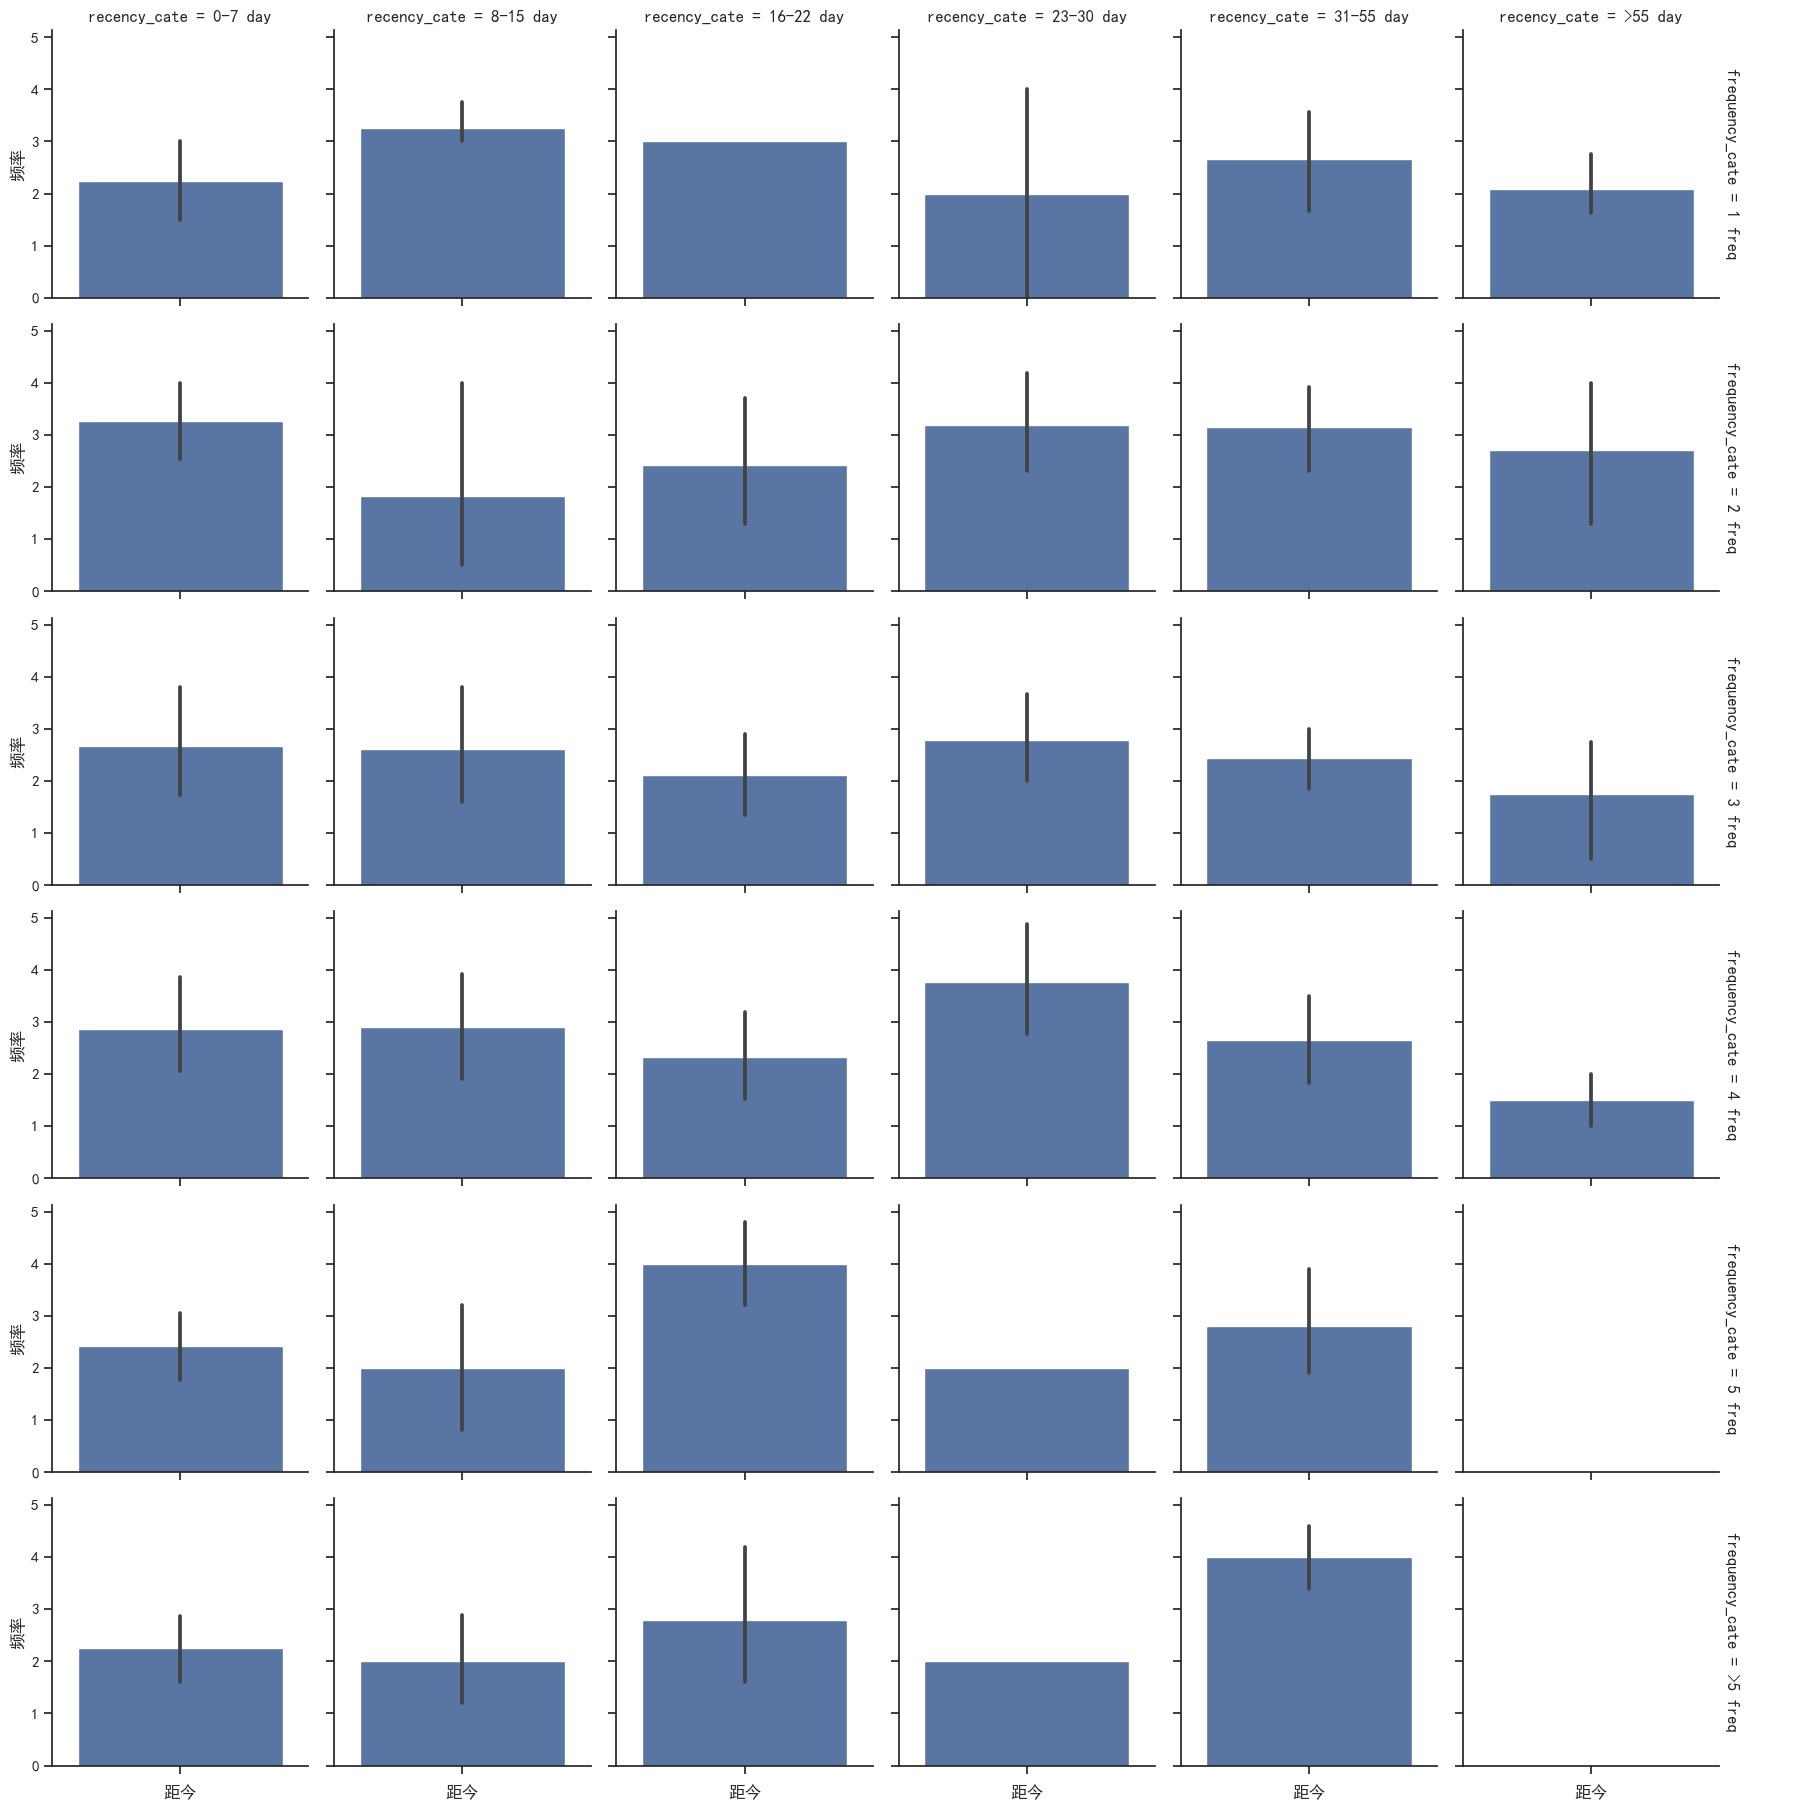

In [16]:
#准备XY轴标签

recency_label =  ['0-7 day', '8-15 day', '16-22 day', '23-30 day', '31-55 day', '>55 day']
frequency_label =  ['1 freq', '2 freq', '3 freq', '4 freq', '5 freq', '>5 freq']

#绘图
'''
    参数：
    col：X轴数据来源
    row：Y轴数据来源
    col_order：X方向数据顺序
    row_order：Y方向数据顺序
    palette：画布色调
    margin_titles：是否合并标题
'''
g = sns.FacetGrid(purchase_list, col="recency_cate", row="frequency_cate", col_order= recency_label, row_order= frequency_label, palette='Set1', margin_titles=True)

# 小图表部分
g = g.map_dataframe(sns.barplot, y ='水')
g = g.set_axis_labels('距今','频率').add_legend()

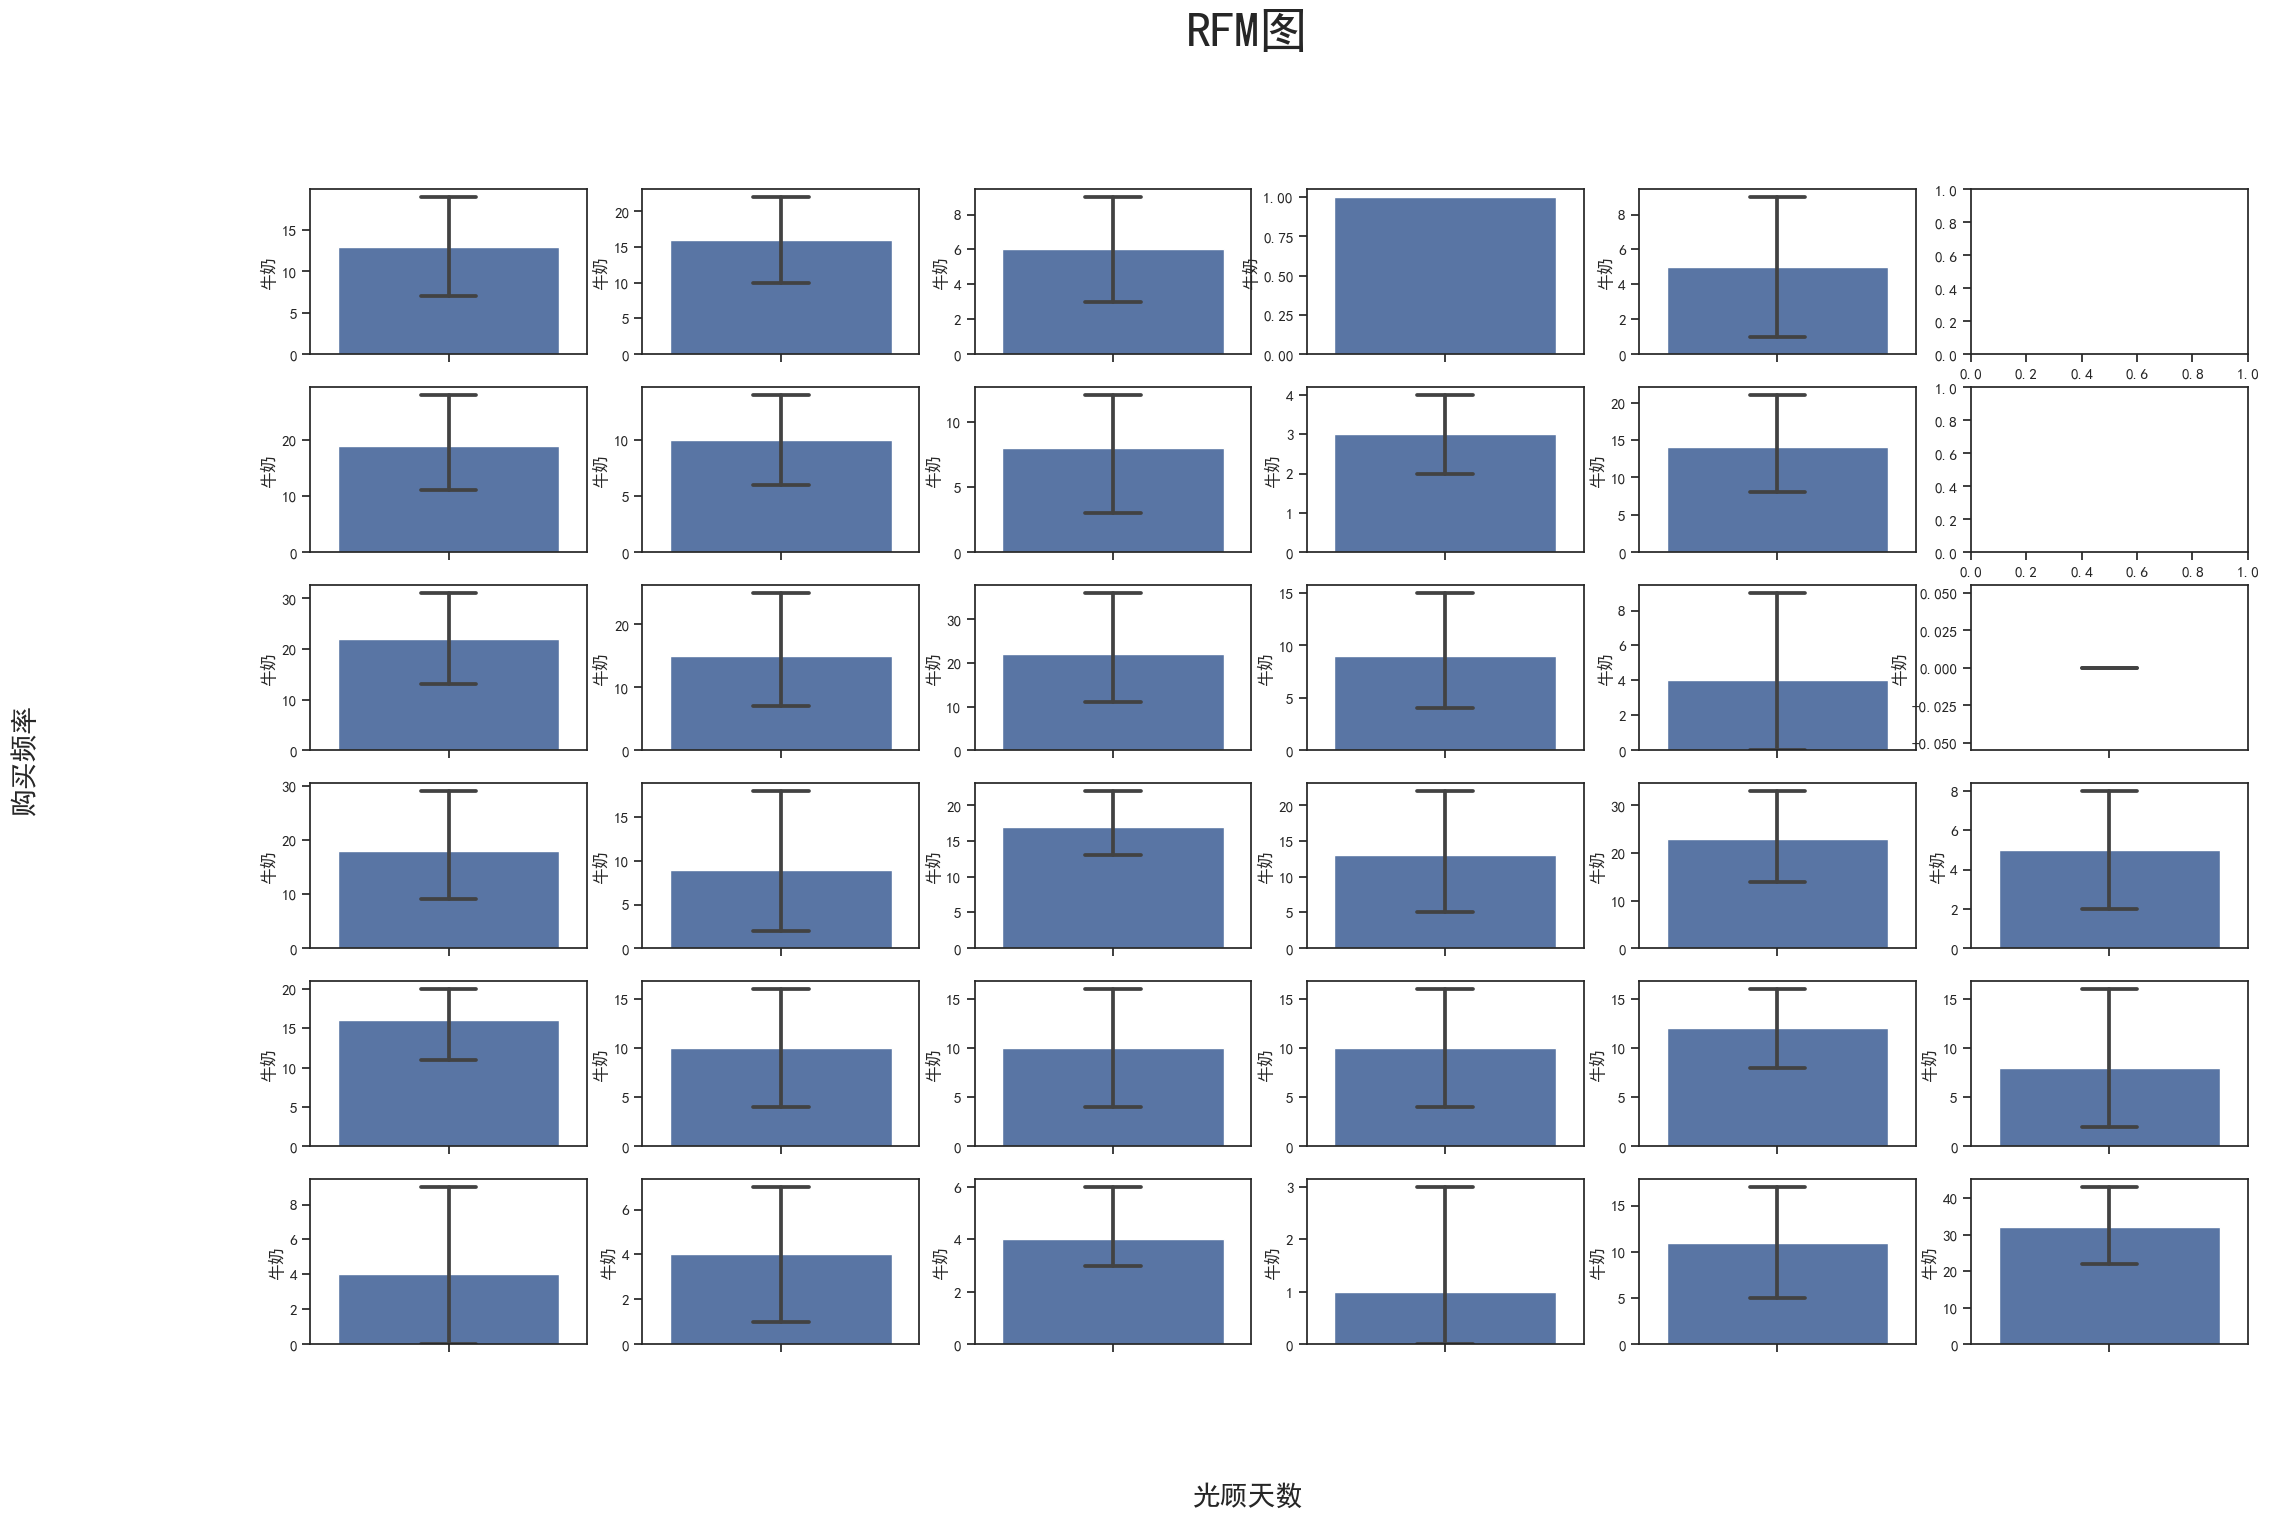

In [89]:
#准备XY轴标签
recency_label =  ['0-7 day', '8-15 day', '16-22 day', '23-30 day', '31-55 day', '>55 day']
frequency_label =  ['1 freq', '2 freq', '3 freq', '4 freq', '5 freq', '>5 freq']


#绘图
#先设定画布大小   6*6 代表有36张小图
fig, axes = plt.subplots(6, 6,figsize=(25,15))
countX = 0 # 画布X轴坐标
for i in frequency_label[::-1]: # 我们内层的小图是从上向下绘制的, 所以要先绘制频率>5次的组别, 需要将列表倒转遍历
    countY = 0 # 画布Y轴坐标
    for j in recency_label: # 最近几天内来过
        data = purchase_list[(purchase_list['recency_cate']==j) & (purchase_list['frequency_cate']==i)]
        if data.shape[0] != 0: # 检查这个位置有没有数据
            # 以下为单一小图表的设定
            sns.barplot(y="牛奶", # 小图表Y数据
                        data=data, #数据来源
                        estimator=np.sum,
                        capsize=.2, # 最高点最低点大小
                        ax=axes[countX, countY]) # 小图表坐标

        countY += 1
    countX += 1
fig.suptitle('RFM图', position=(.5,1), fontsize=35) # 标题
fig.text(0.5, 0.01, '光顾天数', ha='center', va='center', fontsize=20) # 设定X轴标题
fig.text(0.01, 0.5, '购买频率', ha='center', va='center', rotation='vertical', fontsize=20) # 设定Y轴标题
fig.show()

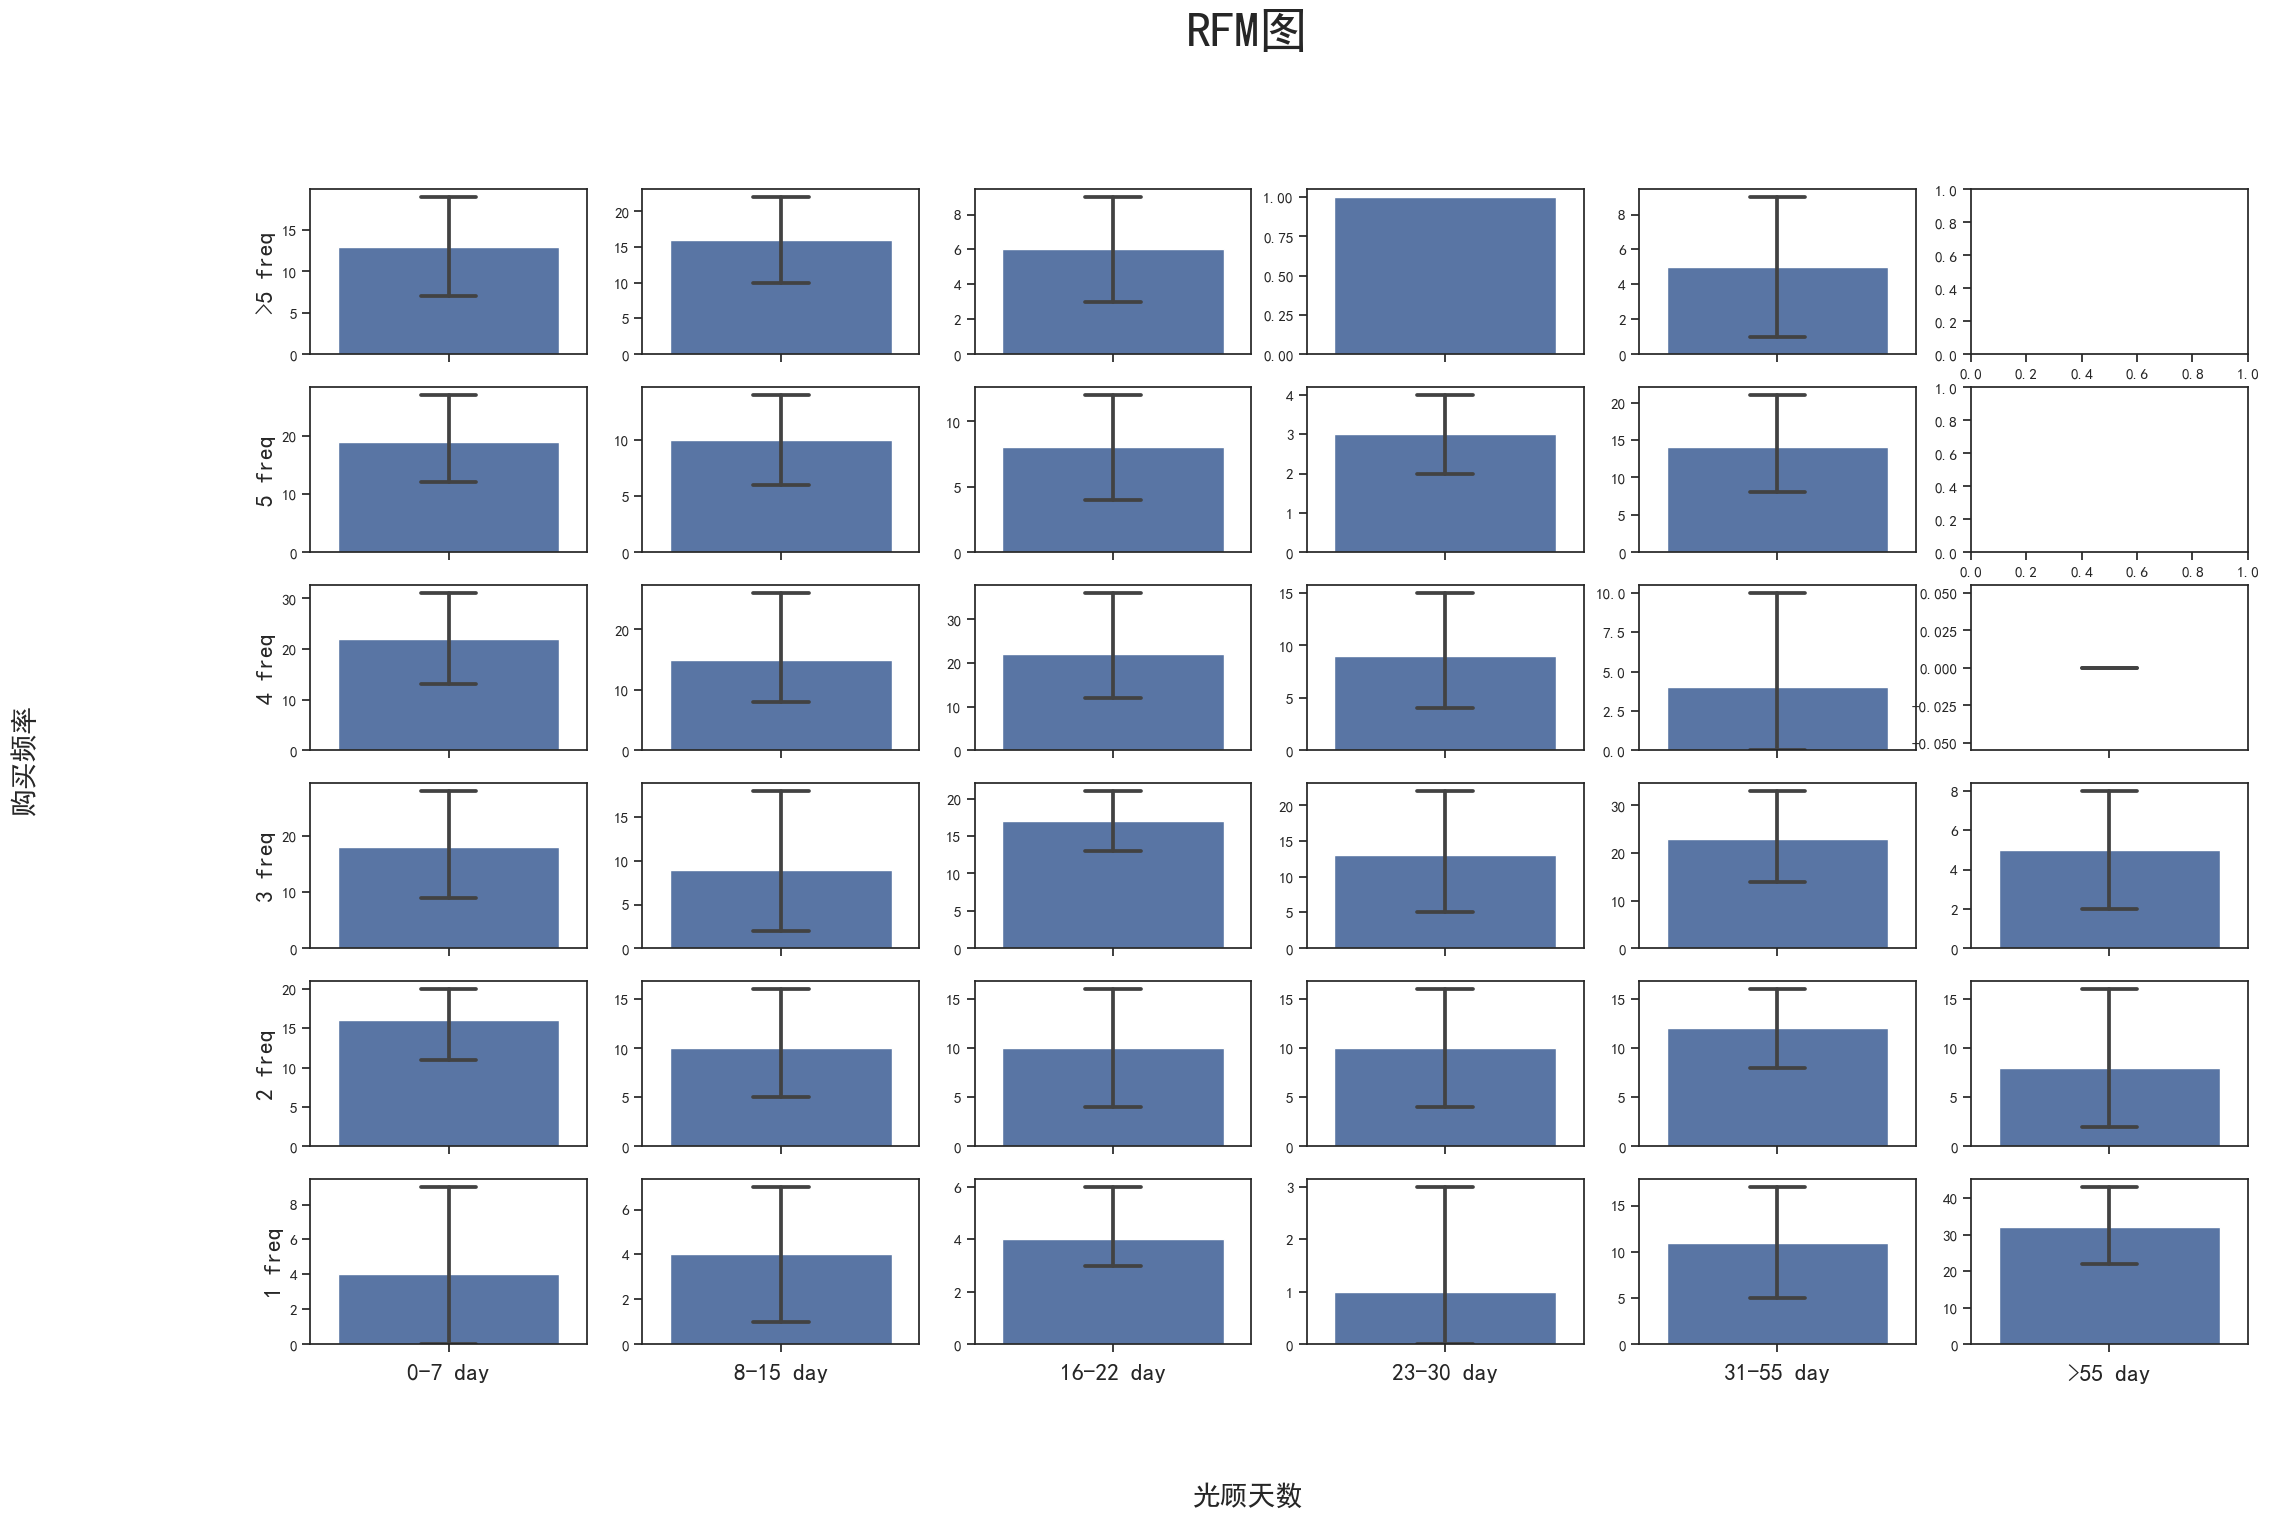

In [17]:
# 4.1 RFM图调整 XY轴统一标签（接下来我们进一步将RFM图细化, 首先把X轴 Y轴的标签填补上）
#先设定画布大小
fig, axes = plt.subplots(6, 6,figsize=(25,15))
countX = 0 # 画布X轴坐标
for i in frequency_label[::-1]: # 我们内层的小图是从上向下绘制的, 所以要先绘制频率>5次的组别, 需要将列表倒转遍历
    countY = 0 # 画布Y轴坐标
    for j in recency_label: # 近因
        data = purchase_list[(purchase_list['recency_cate']==j) & (purchase_list['frequency_cate']==i)]
        if data.shape[0] != 0: #检查这部分有没有数据
            # 下面设定单一小图表
            sns.barplot(y="牛奶", # 小图标Y数据来源
                        data=data, #绘图使用数据
                        estimator=np.sum,
                        capsize=.2, # 最高点最低点大小
                        ax=axes[countX, countY]) # 小图表坐标
        ################ 画X标记################
        if i == '1 freq':
            axes[countX][countY].set_xlabel(j, fontsize=17)

        ############### 画Y标记 ################
        if j == '0-7 day':
            axes[countX][countY].set_ylabel( frequency_label[::-1][countX], fontsize=17)
        else:
            axes[countX][countY].set_ylabel('')

        countY += 1
    countX += 1
fig.suptitle('RFM图', position=(.5,1), fontsize=35) # 标题
fig.text(0.5, 0.01, '光顾天数', ha='center', va='center', fontsize=20) # X轴标题
fig.text(0.01, 0.5, '购买频率', ha='center', va='center', rotation='vertical', fontsize=20) # Y轴标题
fig.show()

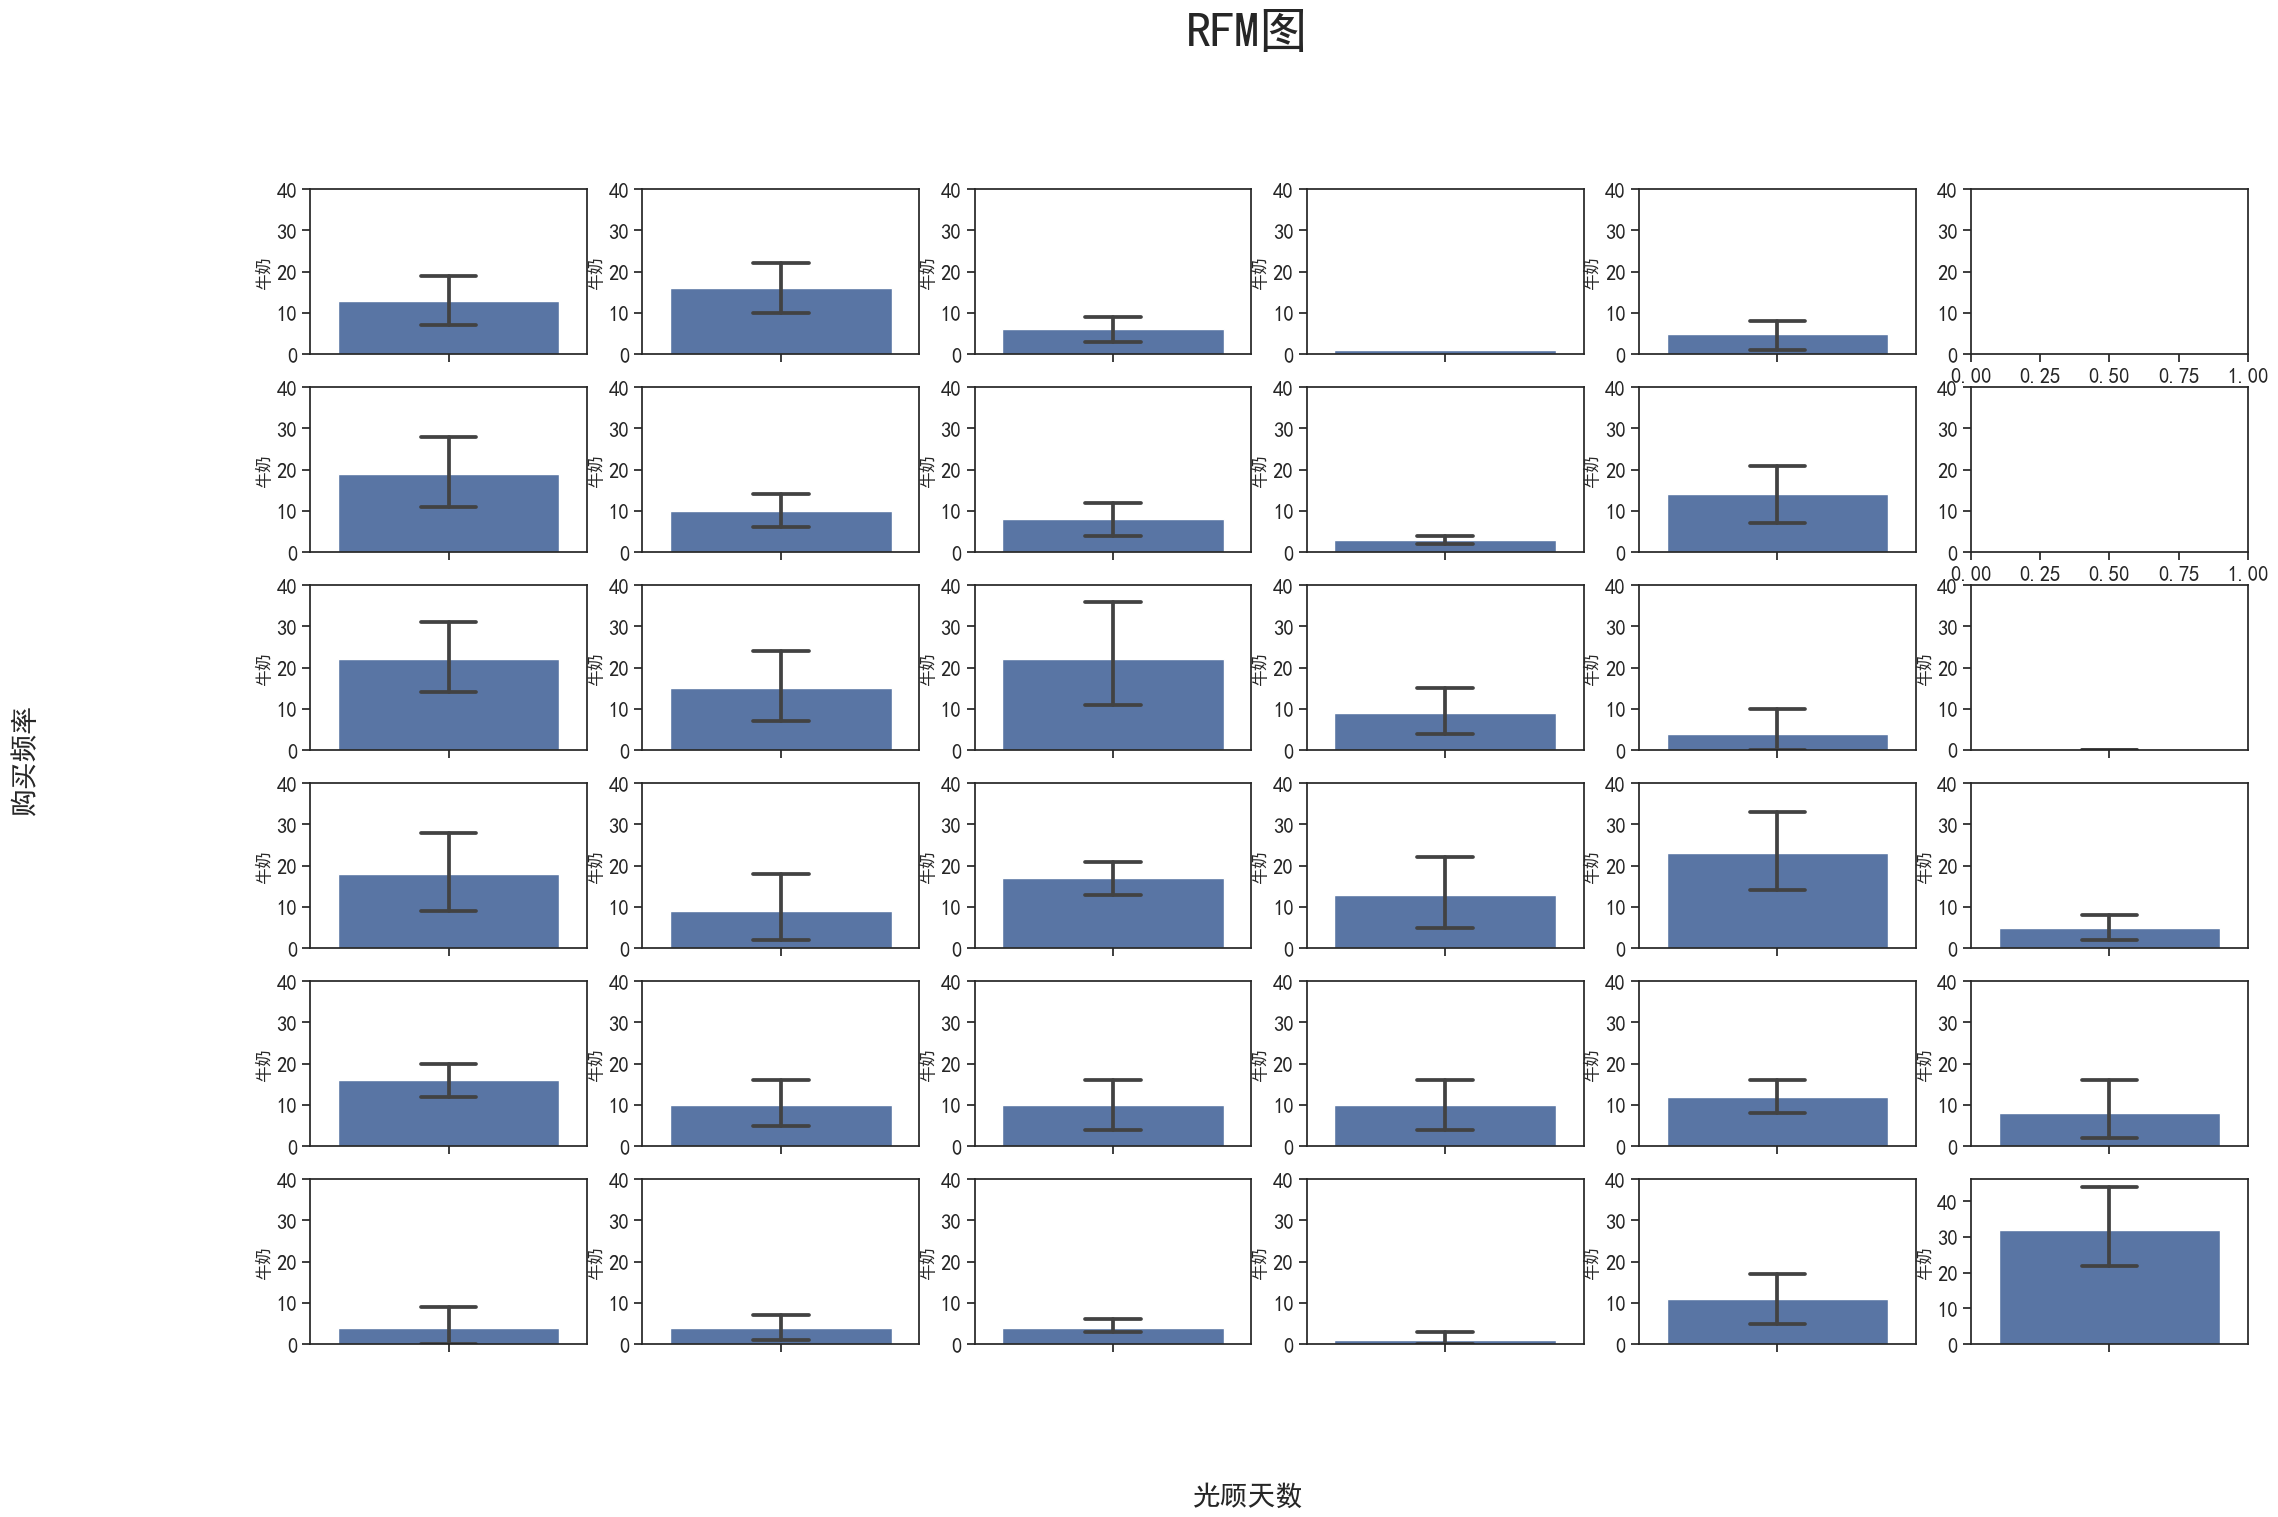

In [18]:
# 4.2 统一Y轴刻度（目前还有一个问题, 就是不同的小图 Y轴数值大小不同, 不方便比较, 我们要将所有的小图Y轴刻度大小）

findbig=0
for i in frequency_label:
    for j in recency_label:
        data = purchase_list[(purchase_list['recency_cate']==j) & (purchase_list['frequency_cate']==i)]
        if data['牛奶'].sum() > findbig:
            findbig = data['牛奶'].sum()


#先设定画布大小
fig, axes = plt.subplots(6, 6,figsize=(25,15))
countX = 0 # 画布X轴坐标
for i in frequency_label[::-1]: # 由于axes画布排列的关系，频率必须要反着放
    countY = 0 # 画布Y轴坐标
    for j in recency_label: # 近因
        data = purchase_list[(purchase_list['recency_cate']==j) & (purchase_list['frequency_cate']==i)]
        if data.shape[0] != 0: #检查这部分有没有数据
            # 下面设定单一小图表
            sns.barplot(y="牛奶", # 小图标Y数据来源
                        data=data, #绘图使用数据
                        estimator=np.sum,
                        capsize=.2, # 最高点最低点大小
                        ax=axes[countX, countY]) # 小图表坐标

        ################ 将水牛奶香蕉的字体变大 ################
        axes[countX][countY].tick_params(labelsize=15)
        ############### 使所有数据尺码相同 ################
        axes[countX][countY].set_yticks(range(0,int(findbig*1.3),10))

        countY += 1
    countX += 1
fig.suptitle('RFM图', position=(.5,1), fontsize=35) # 标题
fig.text(0.5, 0.01, '光顾天数', ha='center', va='center', fontsize=20) # X轴标题
fig.text(0.01, 0.5, '购买频率', ha='center', va='center', rotation='vertical', fontsize=20) # Y轴标题
fig.show()

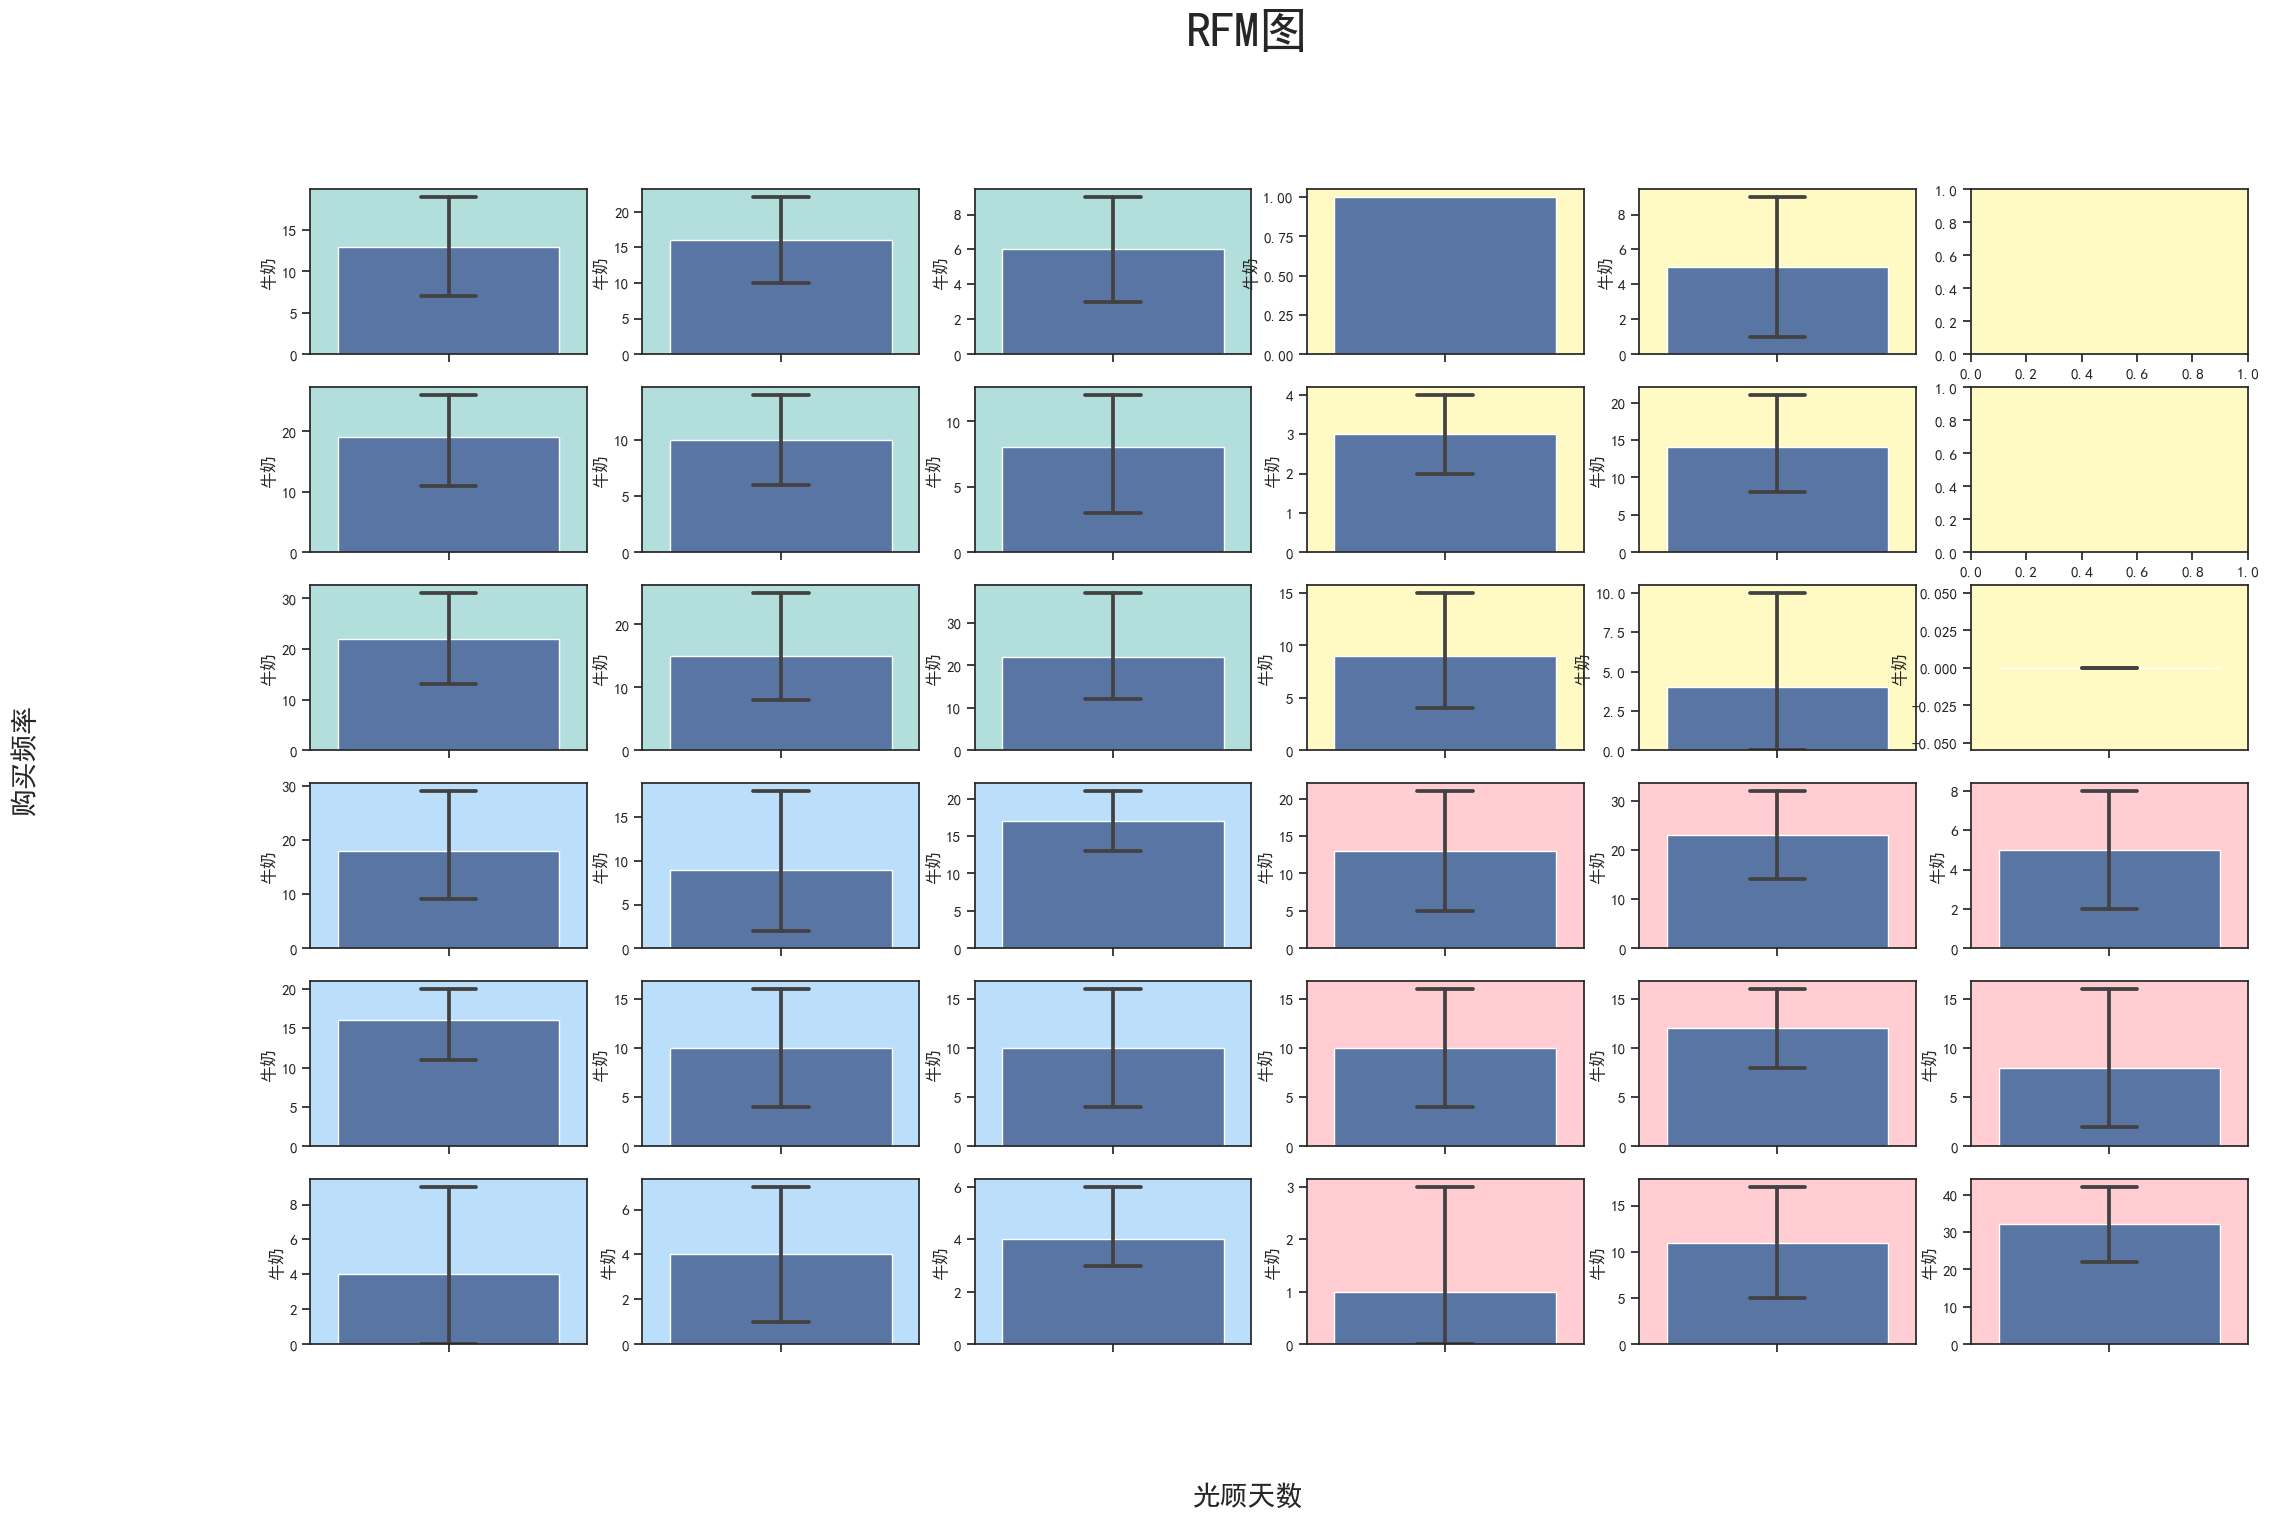

In [19]:
# 4.3 四大类顾客分群

findbig=0
for i in frequency_label:
    for j in recency_label:
        data = purchase_list[(purchase_list['recency_cate']==j) & (purchase_list['frequency_cate']==i)]
        if data['牛奶'].sum() > findbig:
            findbig = data['牛奶'].sum()


#先设定画布大小
fig, axes = plt.subplots(6, 6,figsize=(25,15))
countX = 0 # 画布X轴坐标
for i in frequency_label[::-1]: # 由于axes画布排列的关系，频率必须要反着放
    countY = 0 # 画布Y轴坐标
    for j in recency_label: # 近因
        data = purchase_list[(purchase_list['recency_cate']==j) & (purchase_list['frequency_cate']==i)]
        if data.shape[0] != 0: #检查这部分有没有数据
            # 下面设定单一小图表
            sns.barplot(y="牛奶", # 小图标Y数据来源
                        data=data, #绘图使用数据
                        estimator=np.sum,
                        capsize=.2, # 最高点最低点大小
                        ax=axes[countX, countY]) # 小图表坐标
        ############### 四个区块分颜色 ################
        if countY > 2 and countX > 2:
            axes[countX][countY].set(facecolor="#ffcdd2") #紅色
        elif countY > 2 and countX < 3:
            axes[countX][countY].set(facecolor="#FFF9C4") #黄色
        elif countY < 3 and countX > 2:
            axes[countX][countY].set(facecolor="#BBDEFB") #蓝色
        else:
            axes[countX][countY].set(facecolor="#B2DFDB") #绿色

        countY += 1
    countX += 1
fig.suptitle('RFM图', position=(.5,1), fontsize=35) # 标题
fig.text(0.5, 0.01, '光顾天数', ha='center', va='center', fontsize=20) # X轴标题
fig.text(0.01, 0.5, '购买频率', ha='center', va='center', rotation='vertical', fontsize=20) # Y轴标题
fig.show()

In [20]:

# 4.4 RFM产品分析（ 准备数据绘制完整的RFM分析图）
purchase_list.drop(columns = ['orderId','orderdate','recency','frequency'])

,clientId,gender,水,牛奶,香蕉,recency_cate,frequency_cate,customer
0,1,男性,2.0,2.0,0.0,8-15 day,5 freq,常客
1,2,男性,4.0,1.0,0.0,8-15 day,1 freq,新客
2,3,女性,0.0,0.0,1.0,0-7 day,>5 freq,常客
3,4,女性,2.0,1.0,1.0,>55 day,1 freq,流失客
4,5,男性,0.0,1.0,0.0,16-22 day,4 freq,常客
...,...,...,...,...,...,...,...,...
292,296,男性,1.0,2.0,0.0,23-30 day,4 freq,沉睡客
293,297,女性,4.0,1.0,1.0,0-7 day,2 freq,新客
294,298,女性,1.0,2.0,0.0,16-22 day,4 freq,常客
295,299,女性,2.0,0.0,0.0,>55 day,1 freq,流失客


In [21]:
temp = purchase_list.drop(columns = ['orderId','orderdate','recency','frequency'])
# 将部分数据 宽变长, id_vars 保留不去处理的字段
df3 = pd.melt(temp, id_vars=['clientId','customer','recency_cate','frequency_cate','gender'], var_name='types', value_name='values')
df3

,clientId,customer,recency_cate,frequency_cate,gender,types,values
0,1,常客,8-15 day,5 freq,男性,水,2.0
1,2,新客,8-15 day,1 freq,男性,水,4.0
2,3,常客,0-7 day,>5 freq,女性,水,0.0
3,4,流失客,>55 day,1 freq,女性,水,2.0
4,5,常客,16-22 day,4 freq,男性,水,0.0
...,...,...,...,...,...,...,...
886,296,沉睡客,23-30 day,4 freq,男性,香蕉,0.0
887,297,新客,0-7 day,2 freq,女性,香蕉,1.0
888,298,常客,16-22 day,4 freq,女性,香蕉,0.0
889,299,流失客,>55 day,1 freq,女性,香蕉,0.0


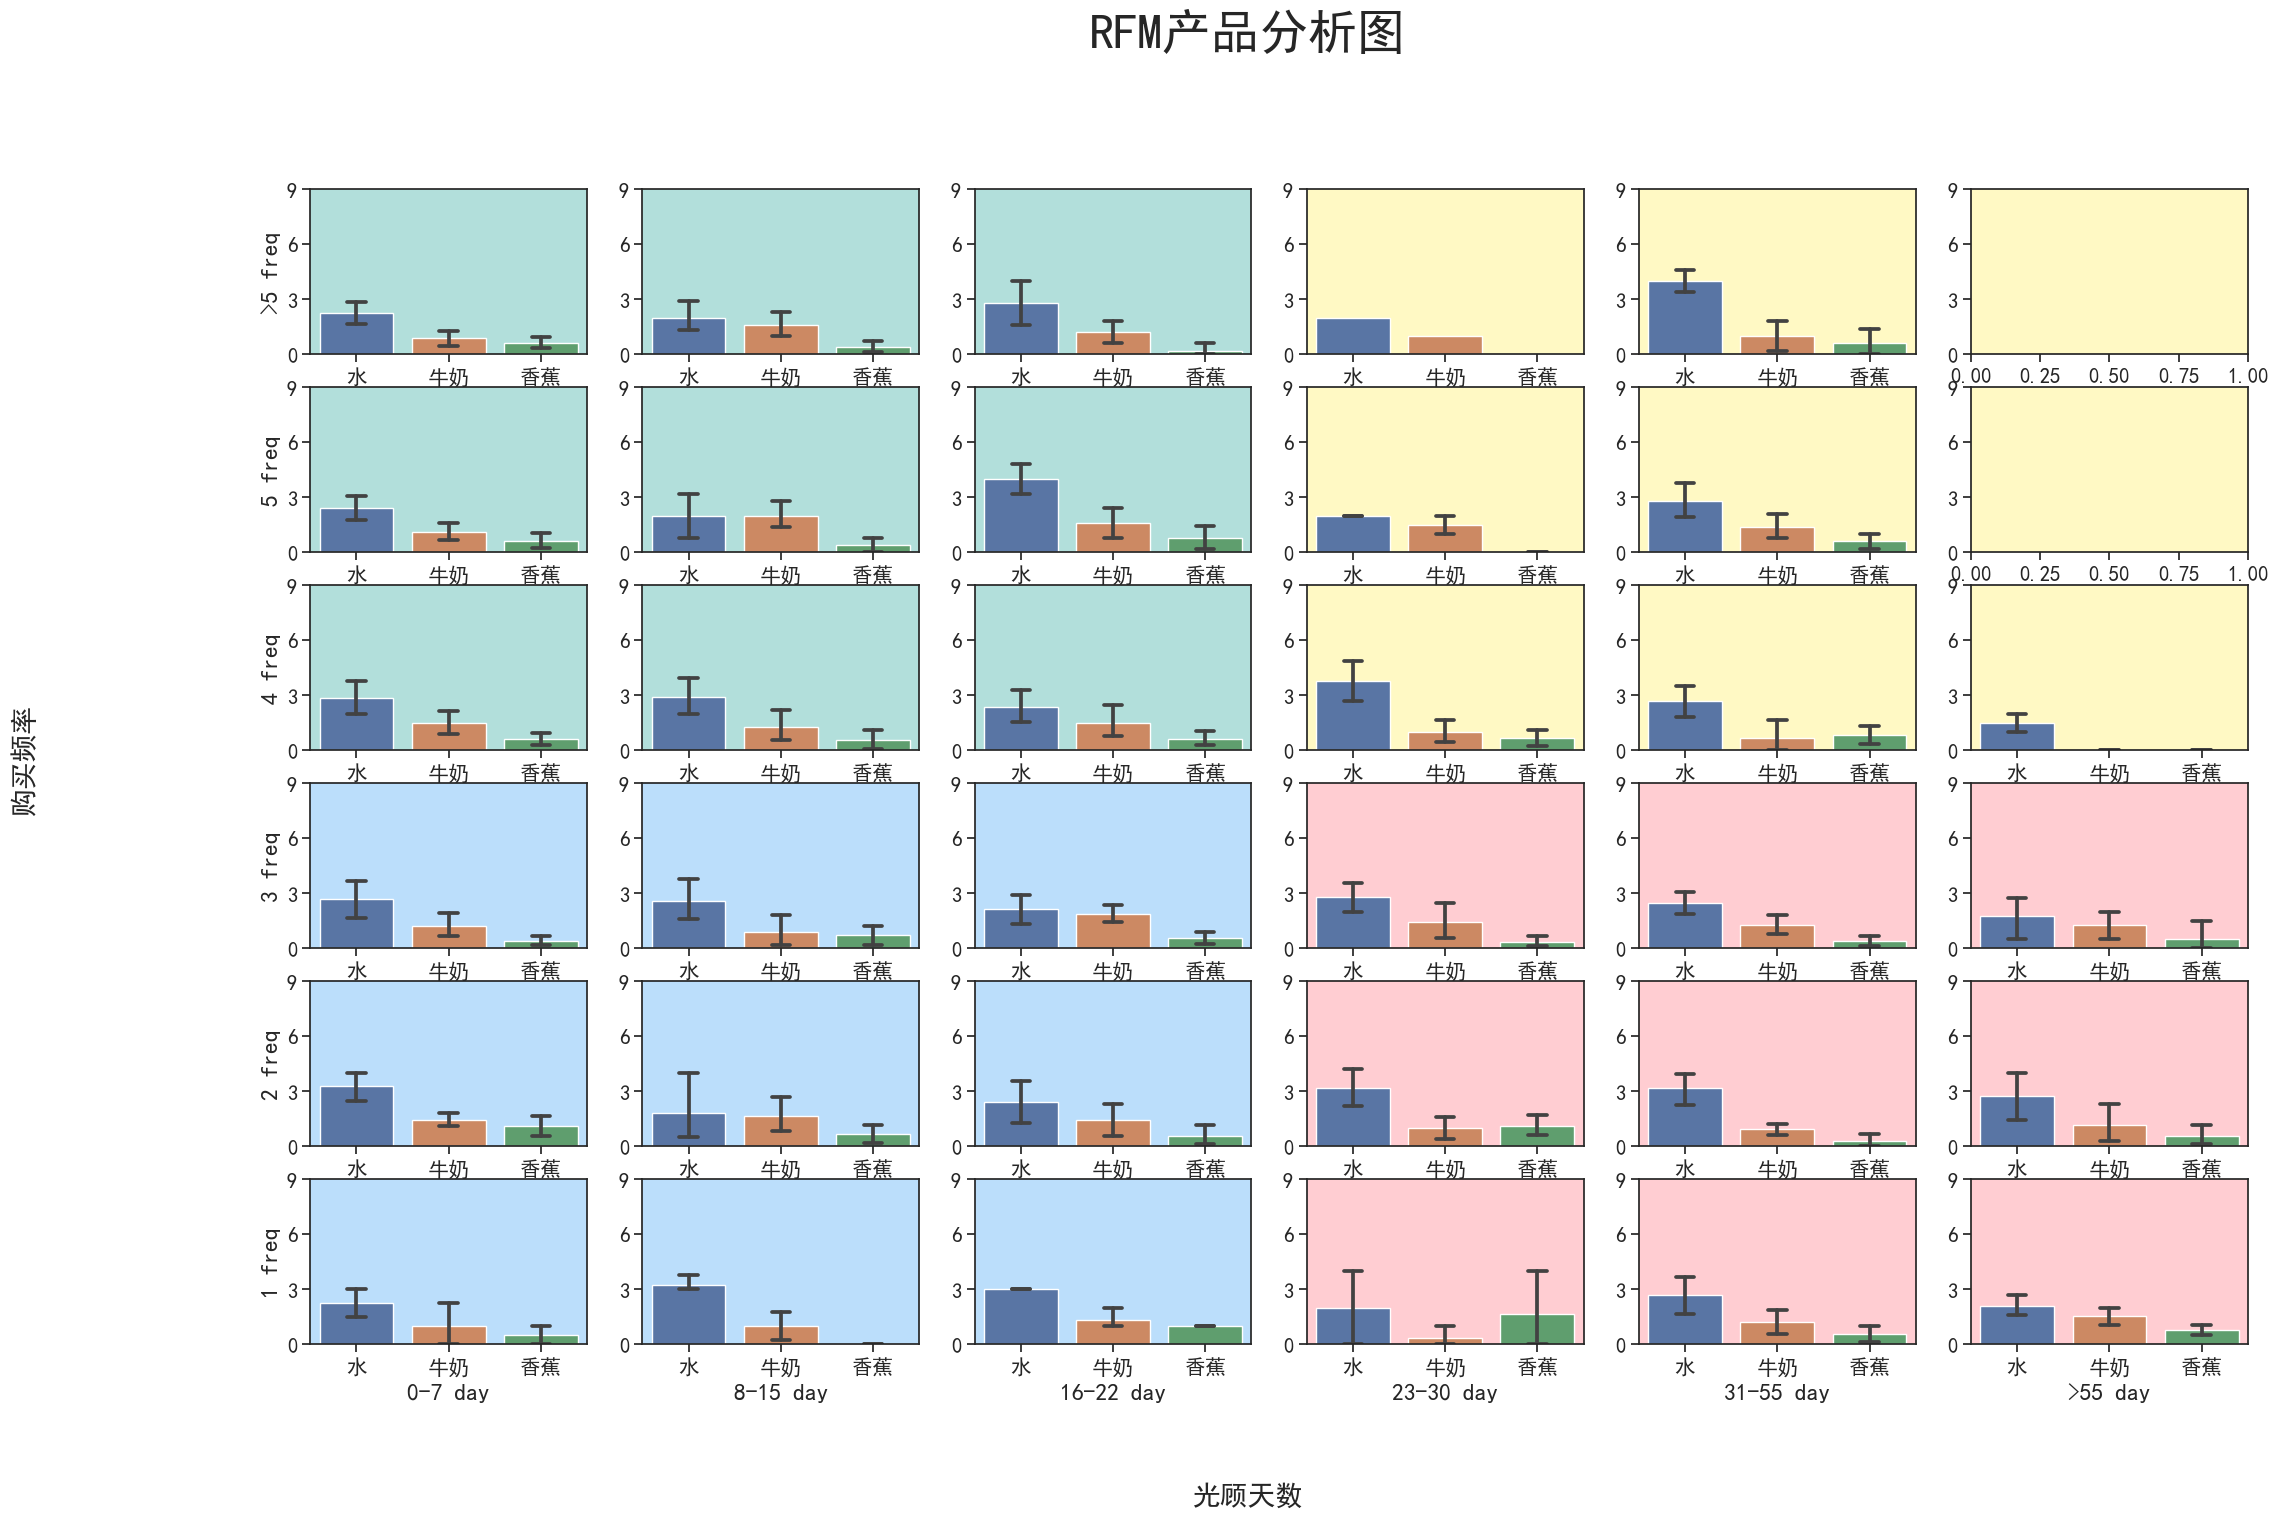

In [22]:
df3 = pd.melt(purchase_list.drop(columns = ['orderId','orderdate','recency','frequency']), id_vars=['clientId','customer','recency_cate','frequency_cate','gender'], var_name='types', value_name='values')
df3['values'] = pd.to_numeric(df3['values'],errors='coerce')
df3 = df3.dropna()

#先设定画布大小
fig, axes = plt.subplots(6, 6,figsize=(25,15))
countX = 0 # 画布X轴坐标
for i in frequency_label[::-1]: # 我们内层的小图是从上向下绘制的, 所以要先绘制频率>5次的组别, 需要将列表倒转遍历
    countY = 0 # 画布Y轴坐标
    for j in recency_label: # 最近R标签数据
        data = df3[(df3['recency_cate']==j) & (df3['frequency_cate']==i)]
        if data.shape[0] != 0: #检查这部分有没有数据
            # 下面绘制每一个小图表
            sns.barplot(x="types", # 小图表X轴数据
                        y="values", # 小图表Y轴数据
                        data=data, #绘图用到的数据
                        capsize=.2,
                        ax=axes[countX, countY]) # 小图表坐标
        # ################ 画X轴刻度 ################
        if i == '1 freq':
            axes[countX][countY].set_xlabel(j, fontsize=17)

        ############### 画Y轴刻度 ################
        if j == '0-7 day':
            axes[countX][countY].set_ylabel( frequency_label[::-1][countX], fontsize=17)
        else:
            axes[countX][countY].set_ylabel('')


        ################ 将水、牛奶、香蕉的字变大################
        axes[countX][countY].tick_params(labelsize=15)
        ############### 统一所有小图的Y轴刻度大小 ################
        axes[countX][countY].set_yticks(range(0,10,3))


        ###############四个区块分颜色 ################
        if countY > 2 and countX > 2:
            axes[countX][countY].set(facecolor="#ffcdd2") #红色
        elif countY > 2 and countX < 3:
            axes[countX][countY].set(facecolor="#FFF9C4") #黃色
        elif countY < 3 and countX > 2:
            axes[countX][countY].set(facecolor="#BBDEFB") #蓝色
        else:
            axes[countX][countY].set(facecolor="#B2DFDB") #绿色

        countY += 1
    countX += 1

fig.suptitle('RFM产品分析图', position=(.5,1), fontsize=35) # 标题
fig.text(0.5, 0.01, '光顾天数', ha='center', va='center', fontsize=20) # X轴标题
fig.text(0.01, 0.5, '购买频率', ha='center', va='center', rotation='vertical', fontsize=20) # Y轴标题
fig.show()

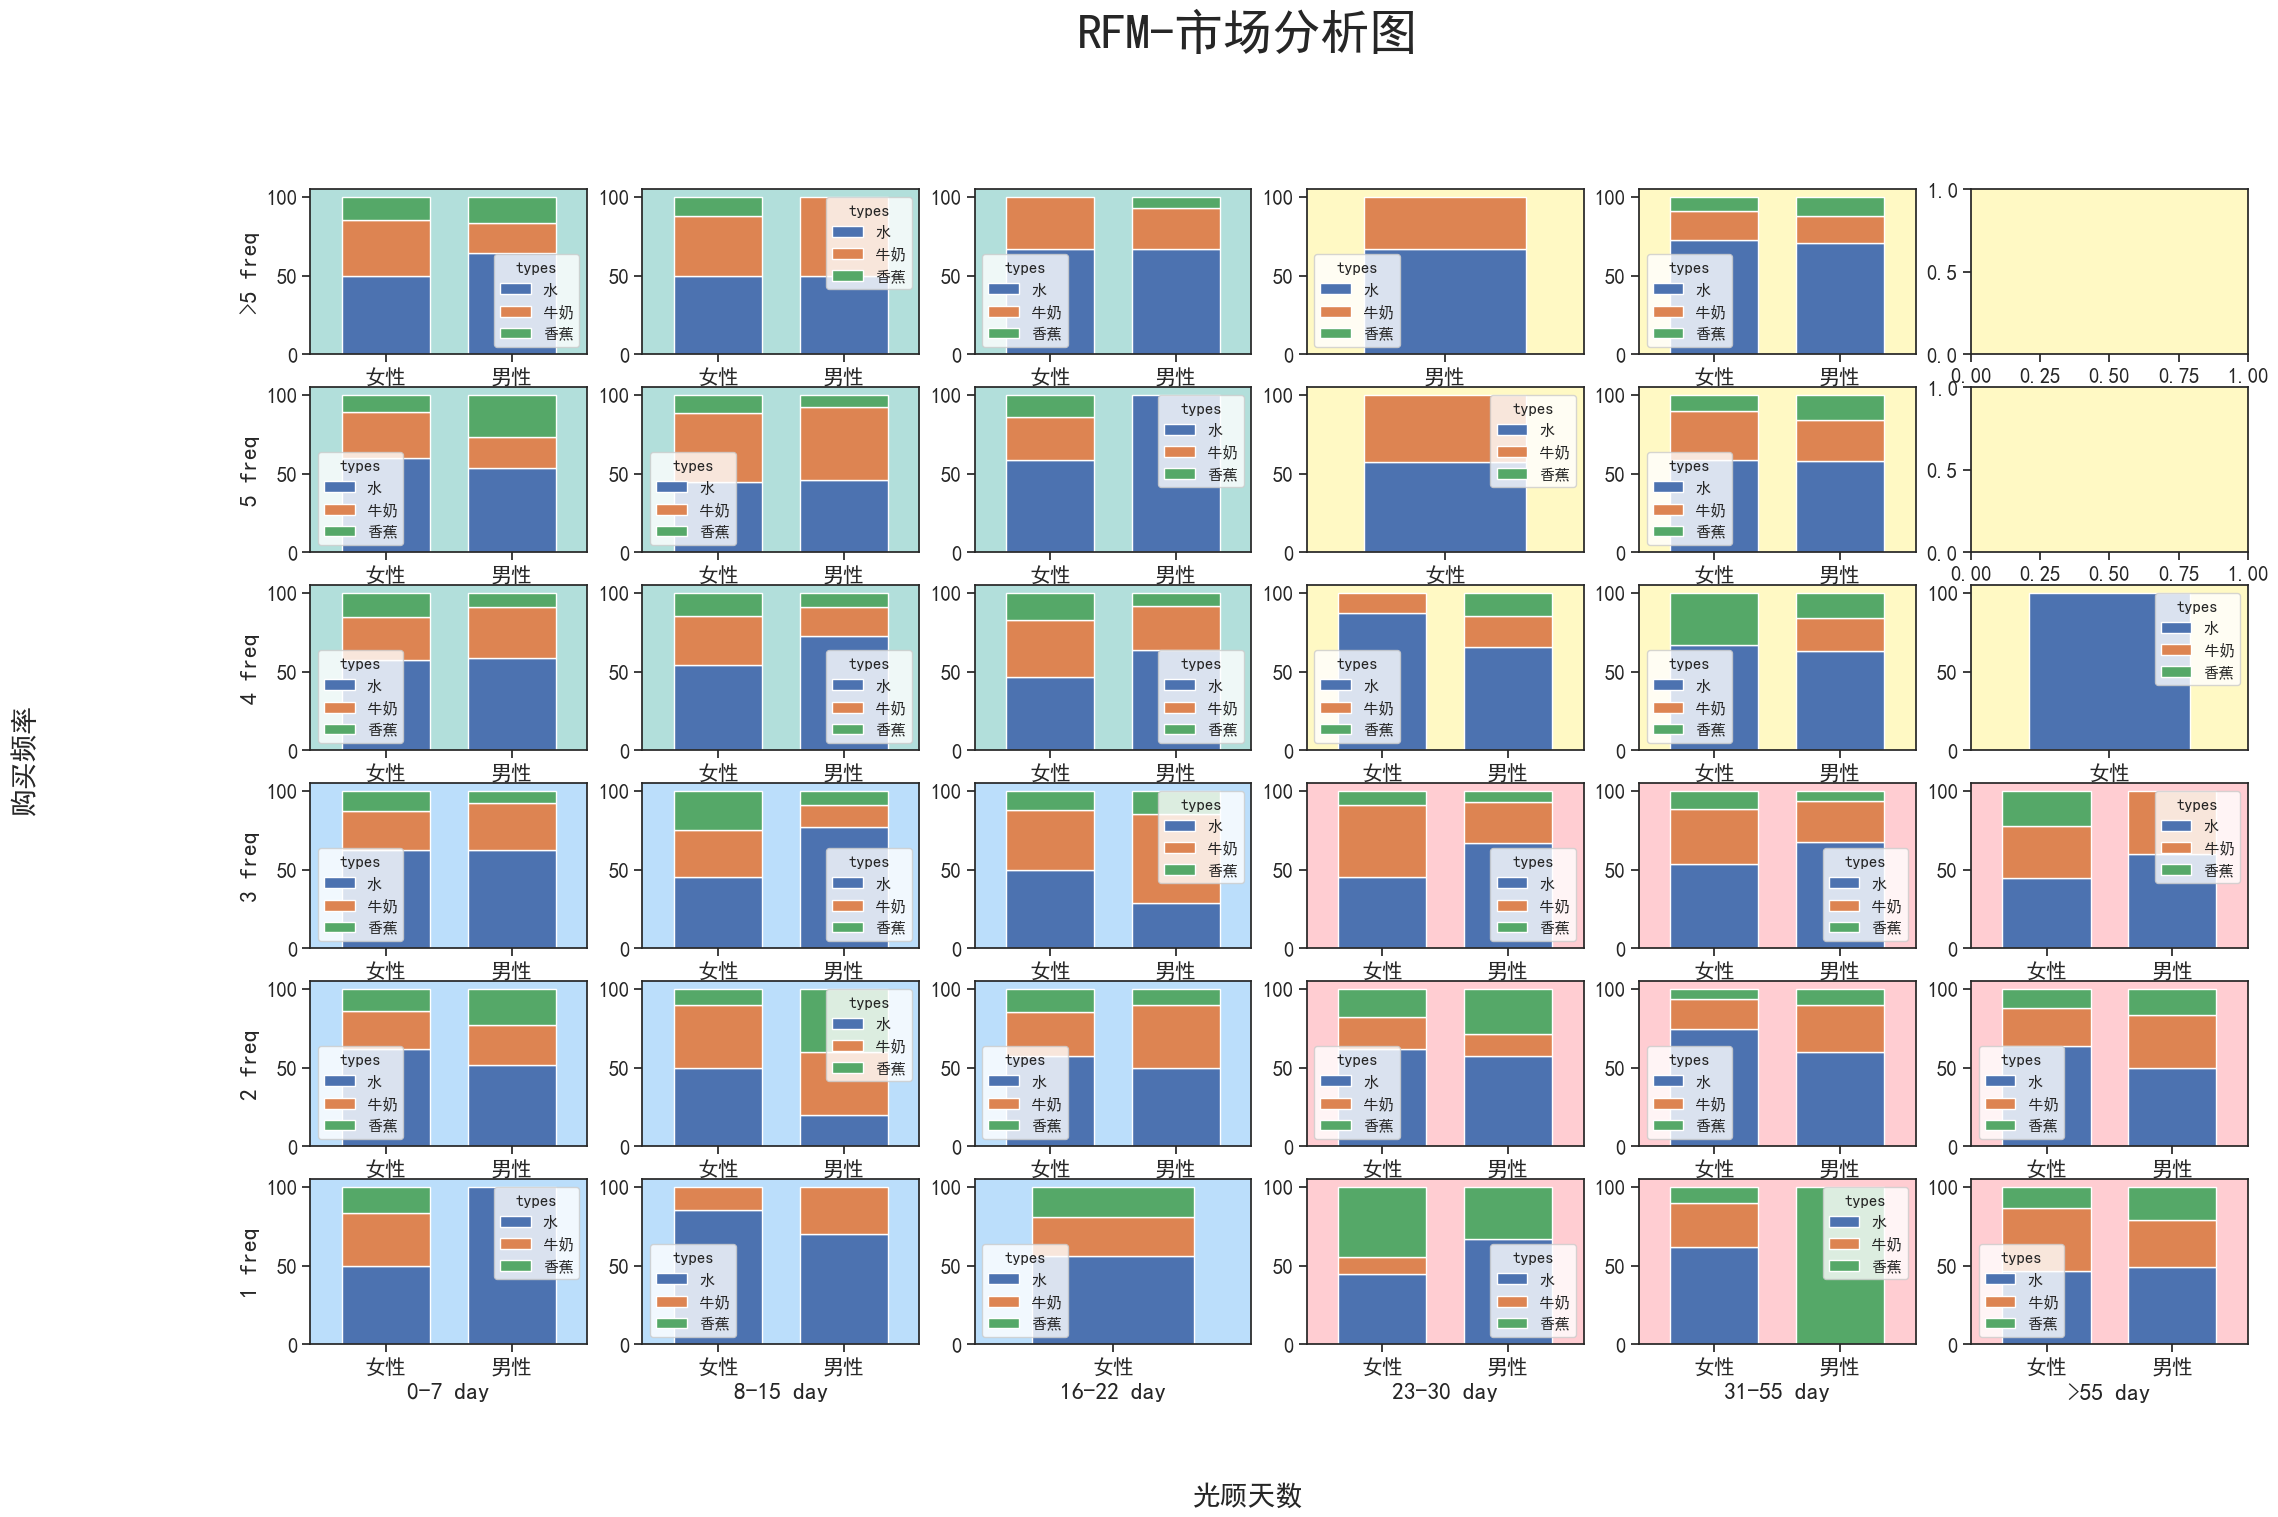

In [135]:
# 5.1 市场分析（接下来我们可以从不同的维度进行拆解, 挖掘不同产品的市场需求情况）

df3 = pd.melt(purchase_list.drop(columns = ['orderId','orderdate','recency','frequency']), id_vars=['clientId','customer','recency_cate','frequency_cate','gender'], var_name='types', value_name='values')
df3['values'] = pd.to_numeric(df3['values'],errors='coerce')
df3 = df3.dropna()

#先设定画布大小
fig, axes = plt.subplots(6, 6,figsize=(25,15))
countX = 0 # 画布X轴坐标
for i in frequency_label[::-1]: # 我们内层的小图是从上向下绘制的, 所以要先绘制频率>5次的组别, 需要将列表倒转遍历
    countY = 0 # 画布Y轴坐标
    for j in recency_label: # 近因
        data = df3[(df3['recency_cate']==j) & (df3['frequency_cate']==i)]
        if data.shape[0] != 0: # 检查这部分有没有数据
            #处理堆叠数据，将这部分数据的购买量,换算成百分比data = data.groupby(['types', 'gender'])['values'].sum() # 依照不同的性別，对购买量求和
            data = data[['gender','types','values']].groupby(['types','gender']).sum()
            # data =data.groupby(level=1, group_keys = False).apply(lambda x:100 * x / float(x.sum())) # 换算成百分比
            data =data.groupby(level=1, group_keys = False).apply(lambda x:100 * x / x.sum()) # 换算成百分比
            data = data.add_suffix('').reset_index() #multiIndex 变平
            #data=data.pivot('gender', 'types', 'values') # 透视表
            data=data.pivot(index ='gender', columns ='types', values='values') # 透视表

            # 下面设定单一小图表
            ax = data.plot.bar(stacked=True, # 设置堆积图
                               width=0.7,# 柱子的宽度
                               legend = True,
                               ax =axes[countX, countY] , # 小图表坐标
                               rot=0) #坐标轴文字旋转

        ################ 画X标记 ################
        if i == '1 freq':
            axes[countX][countY].set_xlabel(j, fontsize=17)

        ############### 画Y标记 ################
        if j == '0-7 day':
            axes[countX][countY].set_ylabel( frequency_label[::-1][countX], fontsize=17)
        else:
            axes[countX][countY].set_ylabel('')


        ################ 将水、牛奶、香蕉的字变大 ################
        axes[countX][countY].tick_params(labelsize=15)


        ############### 四个区块分颜色 ################
        if countY > 2 and countX > 2:
            axes[countX][countY].set(facecolor="#ffcdd2") #红色
        elif countY > 2 and countX < 3:
            axes[countX][countY].set(facecolor="#FFF9C4") #黃色
        elif countY < 3 and countX > 2:
            axes[countX][countY].set(facecolor="#BBDEFB") #蓝色
        else:
            axes[countX][countY].set(facecolor="#B2DFDB") #绿色

        countY += 1
    countX += 1
fig.suptitle('RFM-市场分析图', position=(.5,1), fontsize=35) # 标题
fig.text(0.5, 0.01, '光顾天数', ha='center', va='center', fontsize=20) # X轴标题
fig.text(0.01, 0.5, '购买频率', ha='center', va='center', rotation='vertical', fontsize=20) # Y轴标题
fig.show()

In [136]:
recency_label =  ['0-7 day', '8-15 day', '16-22 day', '23-30 day', '31-55 day', '>55 day']
frequency_label =  ['1 freq', '2 freq', '3 freq', '4 freq', '5 freq', '>5 freq']

In [146]:
data = df3[(df3['recency_cate']=='0-7 day') & (df3['frequency_cate']== '>5 freq')]

In [147]:
data.head()

,clientId,customer,recency_cate,frequency_cate,gender,types,values
2,3,常客,0-7 day,>5 freq,女性,水,0.0
17,18,常客,0-7 day,>5 freq,男性,水,1.0
58,60,常客,0-7 day,>5 freq,男性,水,3.0
64,67,常客,0-7 day,>5 freq,男性,水,1.0
67,70,常客,0-7 day,>5 freq,男性,水,1.0


In [148]:
data = data[['gender','types','values']].groupby(['types','gender']).sum()
data

values
types gender        
水     女性         7.0
      男性        27.0
牛奶    女性         5.0
      男性         8.0
香蕉    女性         2.0
      男性         7.0

In [149]:
data.index.levels[1]

Index(['女性', '男性'], dtype='object', name='gender')

In [150]:
# 参数level 如果是MultiIndex 可以按照level 的索引进行分组
data =data.groupby(level=1, group_keys = False).apply(lambda x:100 * x / float(x.sum())) # 将具体值换成百分比表示
data

/tmp/ipykernel_15459/3616176714.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  data =data.groupby(level=1, group_keys = False).apply(lambda x:100 * x / float(x.sum())) # 将具体值换成百分比表示


values
types gender           
水     女性      50.000000
      男性      64.285714
牛奶    女性      35.714286
      男性      19.047619
香蕉    女性      14.285714
      男性      16.666667

In [151]:
data = data.add_suffix('').reset_index() #将MultiIndex转变成普通索引
data

,types,gender,values
0,水,女性,50.000000
1,水,男性,64.285714
2,牛奶,女性,35.714286
3,牛奶,男性,19.047619
4,香蕉,女性,14.285714
5,香蕉,男性,16.666667


In [153]:
# data=data.pivot('gender', 'types', 'values') # 透视
data=data.pivot(index ='gender', columns ='types', values='values') # 透视
data

types,水,牛奶,香蕉
gender,,,
女性,50.000000,35.714286,14.285714
男性,64.285714,19.047619,16.666667


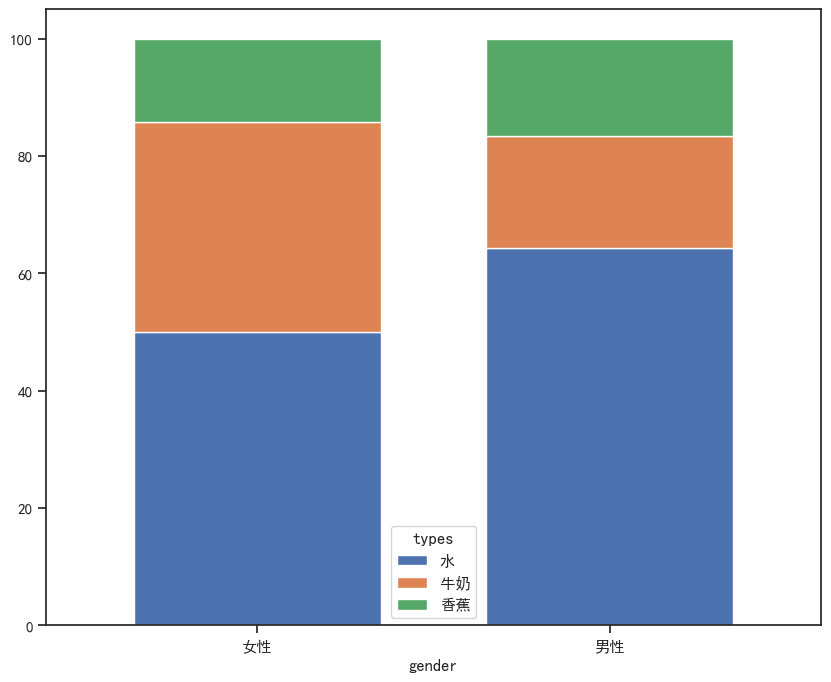

In [154]:
ax = data.plot.bar(stacked=True, # 设定堆积图
                   width=0.7,# 柱子的宽度
                   legend = True,
                   rot=0)

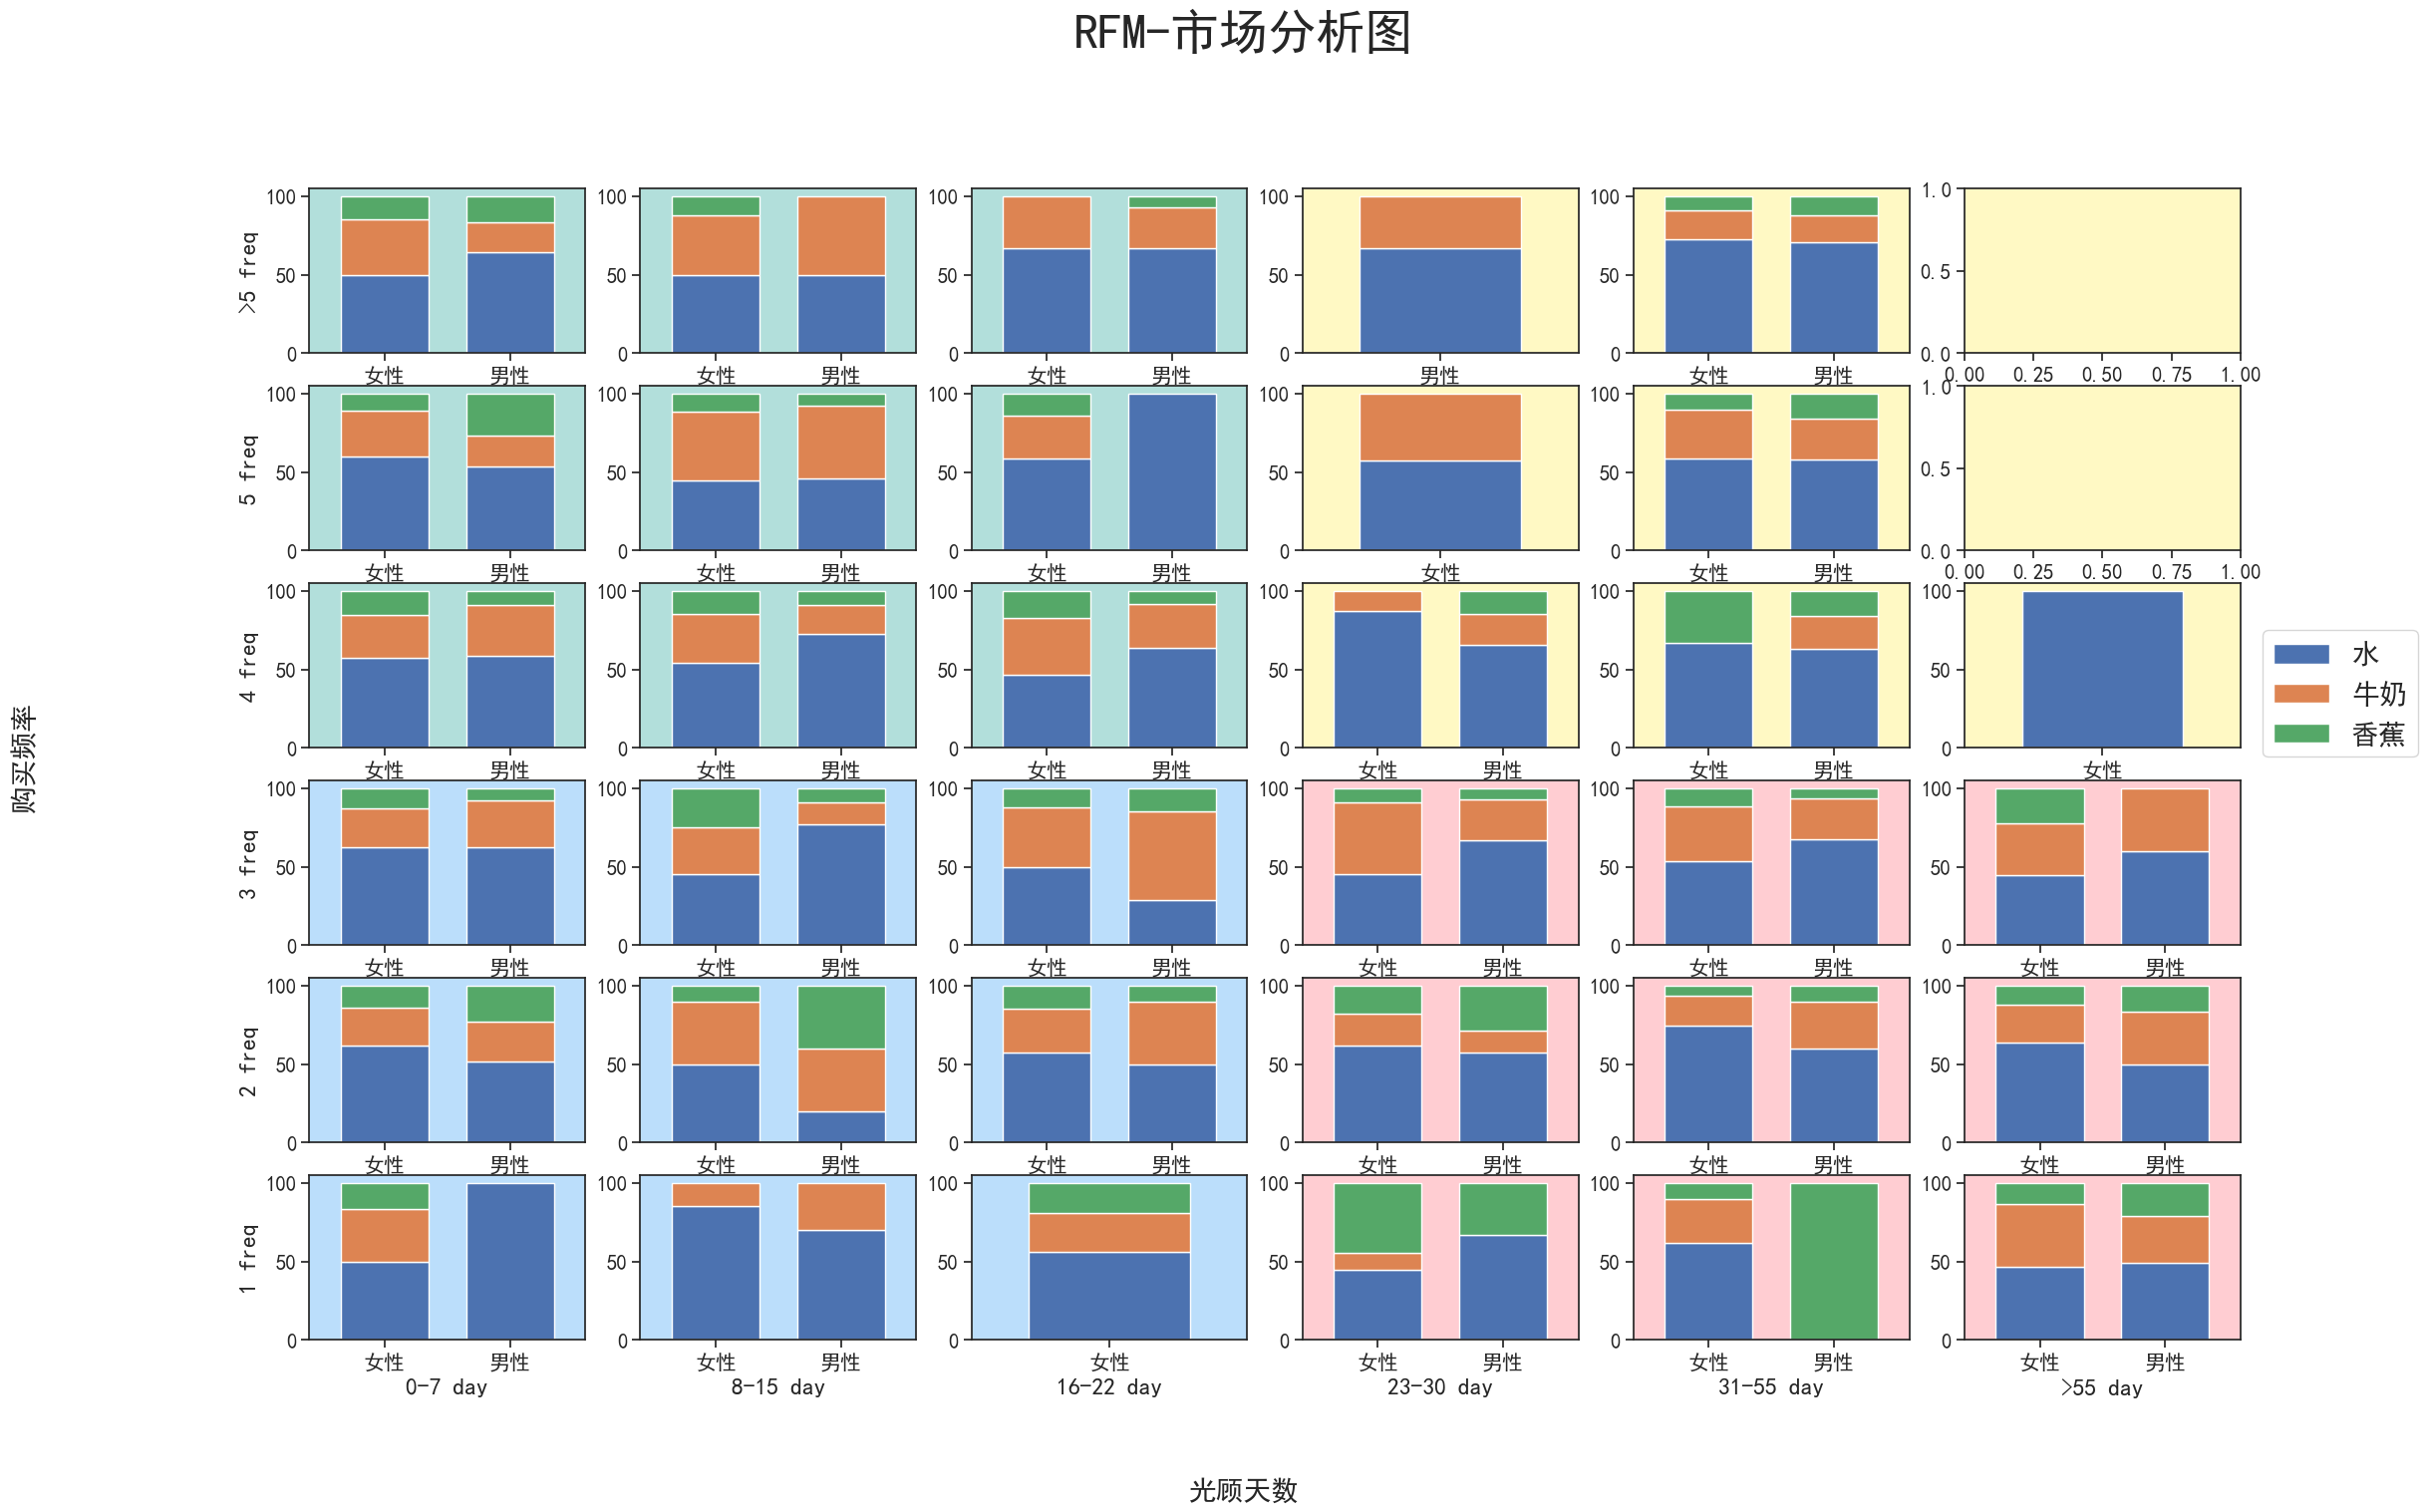

In [156]:
# 5.2 市场分析图例优化
# - 上面的图中，每个小图都有一个图例， 而且每个图例的内容都是一样的， 我们可以让图例只出现一次
# - 绘制每个小图时指定参数legend = False, 在小图中关闭图例
# - 并且在绘图过程中,绘制一次图例即可

#先设定画布大小
fig, axes = plt.subplots(6, 6,figsize=(25,15))
countX = 0 # 画布X轴坐标
for i in frequency_label[::-1]: # 我们内层的小图是从上向下绘制的, 所以要先绘制频率>5次的组别, 需要将列表倒转遍历
    countY = 0 # 画布Y轴坐标
    for j in recency_label: # 近因
        data = df3[(df3['recency_cate']==j) & (df3['frequency_cate']==i)]
        if data.shape[0] != 0: #检查这部分有没有数据
            # 处理堆叠数据，将这部分数据的购买量,换算成百分比data = data.groupby(['types', 'gender'])['values'].sum() # 依照不同的性別，对购买量求和
            data = data[['gender','types','values']].groupby(['types','gender']).sum()
            #data =data.groupby(level=1, group_keys = False).apply(lambda x:100 * x / float(x.sum())) # 换算成百分比
            data =data.groupby(level=1, group_keys = False).apply(lambda x:100 * x / x.sum()) # 换算成百分比
            data = data.add_suffix('').reset_index() #multiIndex 变平
            # data=data.pivot('gender', 'types', 'values') # 透视表
            data=data.pivot(index ='gender', columns ='types', values='values') # 透视表

            # 下面设定单一小图表
            ax = data.plot.bar(stacked=True, # 设置堆积图
                               width=0.7,# 柱子的宽度
                               legend = False,
                               ax =axes[countX, countY] , # 小图表坐标
                               rot=0) #坐标轴文字旋转

        ################ 设定图例 ################
        if (i == '4 freq') and (j == '>55 day'):
            ax.legend(bbox_to_anchor=(1.03, 0.8), loc=2, fontsize =20) #设定图例

        ################ 画X标记 ################
        if i == '1 freq':
            axes[countX][countY].set_xlabel(j, fontsize=17)

        ###############  画Y标记 ################
        if j == '0-7 day':
            axes[countX][countY].set_ylabel( frequency_label[::-1][countX], fontsize=17)
        else:
            axes[countX][countY].set_ylabel('')


        ################ 将水、牛奶、香蕉的字变大 ################
        axes[countX][countY].tick_params(labelsize=15)


        ############### 四个区块分颜色 ################
        if countY > 2 and countX > 2:
            axes[countX][countY].set(facecolor="#ffcdd2") #红色
        elif countY > 2 and countX < 3:
            axes[countX][countY].set(facecolor="#FFF9C4") #黃色
        elif countY < 3 and countX > 2:
            axes[countX][countY].set(facecolor="#BBDEFB") #蓝色
        else:
            axes[countX][countY].set(facecolor="#B2DFDB") #绿色

        countY += 1
    countX += 1
fig.suptitle('RFM-市场分析图', position=(.5,1), fontsize=35) # 标题
fig.text(0.5, 0.01, '光顾天数', ha='center', va='center', fontsize=20) # X轴标题
fig.text(0.01, 0.5, '购买频率', ha='center', va='center', rotation='vertical', fontsize=20) # Y轴标题
fig.show()



In [187]:
# 6.1 成本获利分析
# 加载成本数据
cac = pd.read_csv('./file/cac.csv')
cac

,Unnamed: 0,clientId,cac
0,1,1,118
1,2,2,23
2,3,3,66
3,4,4,94
4,5,5,110
...,...,...,...
499995,499996,499996,106
499996,499997,499997,80
499997,499998,499998,9
499998,499999,499999,78


In [188]:
cac = cac[['clientId', 'cac']] #去掉多余数据
cac

,clientId,cac
0,1,118
1,2,23
2,3,66
3,4,94
4,5,110
...,...,...
499995,499996,106
499996,499997,80
499997,499998,9
499998,499999,78


In [189]:
# 计算clvs
clv = orders[['clientId','grossmarg']].groupby('clientId').sum().reset_index() #计算每个顾客的总消费金额
clv

,clientId,grossmarg
0,1,530
1,2,90
2,3,480
3,4,80
4,5,450
...,...,...
284,296,310
285,297,140
286,298,340
287,299,20


In [190]:
clv.columns = ['clientId', 'clv'] #重命名列名
clv

,clientId,clv
0,1,530
1,2,90
2,3,480
3,4,80
4,5,450
...,...,...
284,296,310
285,297,140
286,298,340
287,299,20


In [192]:
# purchase_list,clv,cac 合起来（merge）
purchase_list =  purchase_list.merge(clv,on=['clientId'])
purchase_list =  purchase_list.merge(cac,on=['clientId'])
purchase_list

MergeError: Passing 'suffixes' which cause duplicate columns {'clv_x'} is not allowed.

In [193]:
# 计算不同分组的clv与cac
countfinal = purchase_list[['frequency_cate', 'recency_cate','clv', 'cac']].groupby(['frequency_cate', 'recency_cate'], ).sum().reset_index()
countfinal

/tmp/ipykernel_15459/3066294514.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  countfinal = purchase_list[['frequency_cate', 'recency_cate','clv', 'cac']].groupby(['frequency_cate', 'recency_cate'], ).sum().reset_index()


,frequency_cate,recency_cate,clv,cac
0,1 freq,0-7 day,310,402
1,1 freq,8-15 day,330,310
2,1 freq,16-22 day,320,157
3,1 freq,23-30 day,160,149
4,1 freq,31-55 day,840,792
5,1 freq,>55 day,2200,1616
6,2 freq,0-7 day,2250,1070
7,2 freq,8-15 day,1550,436
8,2 freq,16-22 day,1220,617
9,2 freq,23-30 day,1900,834


In [194]:
# 将clv与cac做melt转换
finaldf = pd.melt(countfinal, id_vars=['frequency_cate','recency_cate'], value_vars=['clv', 'cac'])
finaldf

,frequency_cate,recency_cate,variable,value
0,1 freq,0-7 day,clv,310
1,1 freq,8-15 day,clv,330
2,1 freq,16-22 day,clv,320
3,1 freq,23-30 day,clv,160
4,1 freq,31-55 day,clv,840
...,...,...,...,...
67,>5 freq,8-15 day,cac,928
68,>5 freq,16-22 day,cac,451
69,>5 freq,23-30 day,cac,115
70,>5 freq,31-55 day,cac,391


In [302]:
# 缺失值补0
finaldf['value'] = finaldf['value'].fillna(0)
finaldf.to_csv('./file/finaldf.csv' , index=0)

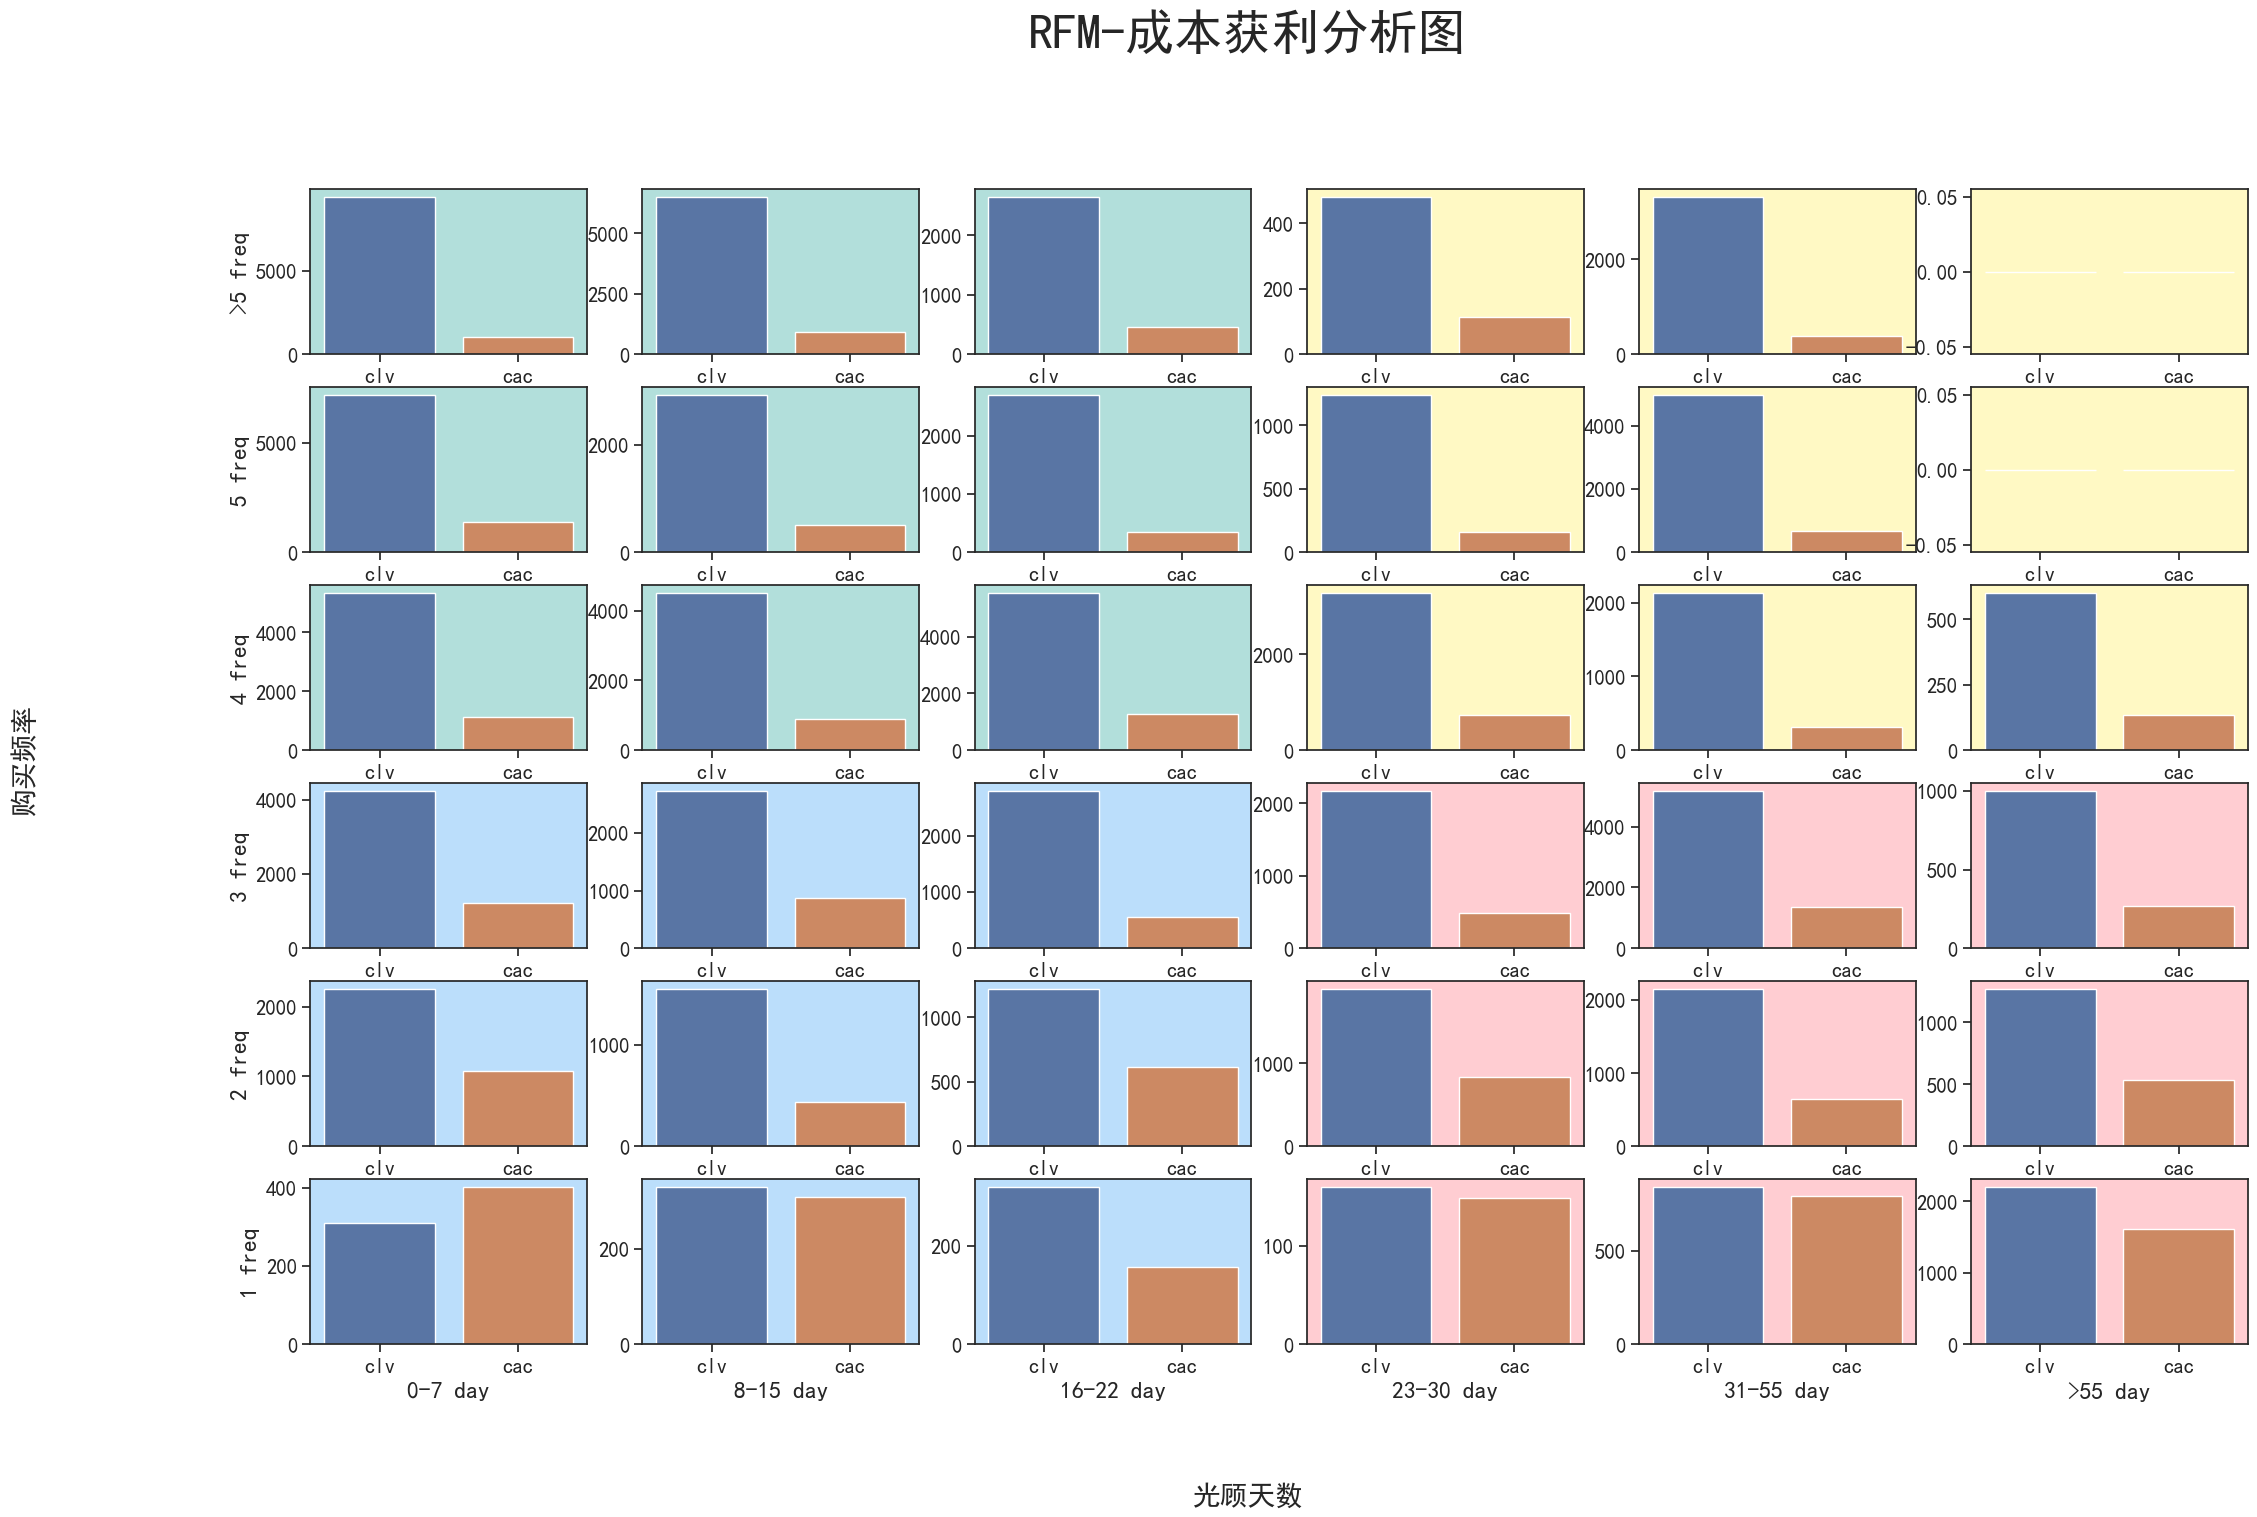

In [196]:
#先设定画布大小
fig, axes = plt.subplots(6, 6,figsize=(25,15))
countX = 0 #  画布X轴坐标
for i in frequency_label[::-1]: # 我们内层的小图是从上向下绘制的, 所以要先绘制频率>5次的组别, 需要将列表倒转遍历
    countY = 0 # 画布Y轴坐标
    for j in recency_label: # 近因
        data = finaldf[(finaldf['recency_cate']==j) & (finaldf['frequency_cate']==i)]
        if data.shape[0] != 0: #  检查这部分有没有数据
            # 下面设定单一小图表
            sns.barplot(x="variable", # 指定小图标X轴数据
                        y="value", # 指定小图标y轴数据
                        data=data, #绘图使用的DataFrame
                        capsize=.2,
                        ax=axes[countX, countY]) # 小图表坐标


        ################ 设定图例 ################
        # if (i == '4 freq') and (j == '>55 day'):
        #     axes.legend(bbox_to_anchor=(1.03, 0.8), loc=2, fontsize =20) #设定图例

        ################ 画X标签 ################
        if i == '1 freq':
            axes[countX][countY].set_xlabel(j, fontsize=17)

        ############### 画Y标签 ################
        if j == '0-7 day':
            axes[countX][countY].set_ylabel( frequency_label[::-1][countX], fontsize=17)
        else:
            axes[countX][countY].set_ylabel('')


        ################ 将水、牛奶、香蕉的字变大 ################
        axes[countX][countY].tick_params(labelsize=15)


        ############### 四个区块分颜色 ################
        if countY > 2 and countX > 2:
            axes[countX][countY].set(facecolor="#ffcdd2") #红色
        elif countY > 2 and countX < 3:
            axes[countX][countY].set(facecolor="#FFF9C4") #黄色
        elif countY < 3 and countX > 2:
            axes[countX][countY].set(facecolor="#BBDEFB") #蓝色
        else:
            axes[countX][countY].set(facecolor="#B2DFDB") #绿色

        countY += 1
    countX += 1

fig.suptitle('RFM-成本获利分析图', position=(.5,1), fontsize=35) # 标题
fig.text(0.5, 0.01, '光顾天数', ha='center', va='center', fontsize=20) # X轴标题
fig.text(0.01, 0.5, '购买频率', ha='center', va='center', rotation='vertical', fontsize=20) # Y轴标题
fig.show()

In [197]:
# 6.2 RFM毛利率分析
countfinal['毛利'] = countfinal['clv'] - countfinal['cac']
countfinal['毛利检查'] = np.where(countfinal['毛利']< 0,'#ff5858','#58acff')

In [198]:
countfinal

,frequency_cate,recency_cate,clv,cac,毛利,毛利检查
0,1 freq,0-7 day,310,402,-92,#ff5858
1,1 freq,8-15 day,330,310,20,#58acff
2,1 freq,16-22 day,320,157,163,#58acff
3,1 freq,23-30 day,160,149,11,#58acff
4,1 freq,31-55 day,840,792,48,#58acff
5,1 freq,>55 day,2200,1616,584,#58acff
6,2 freq,0-7 day,2250,1070,1180,#58acff
7,2 freq,8-15 day,1550,436,1114,#58acff
8,2 freq,16-22 day,1220,617,603,#58acff
9,2 freq,23-30 day,1900,834,1066,#58acff


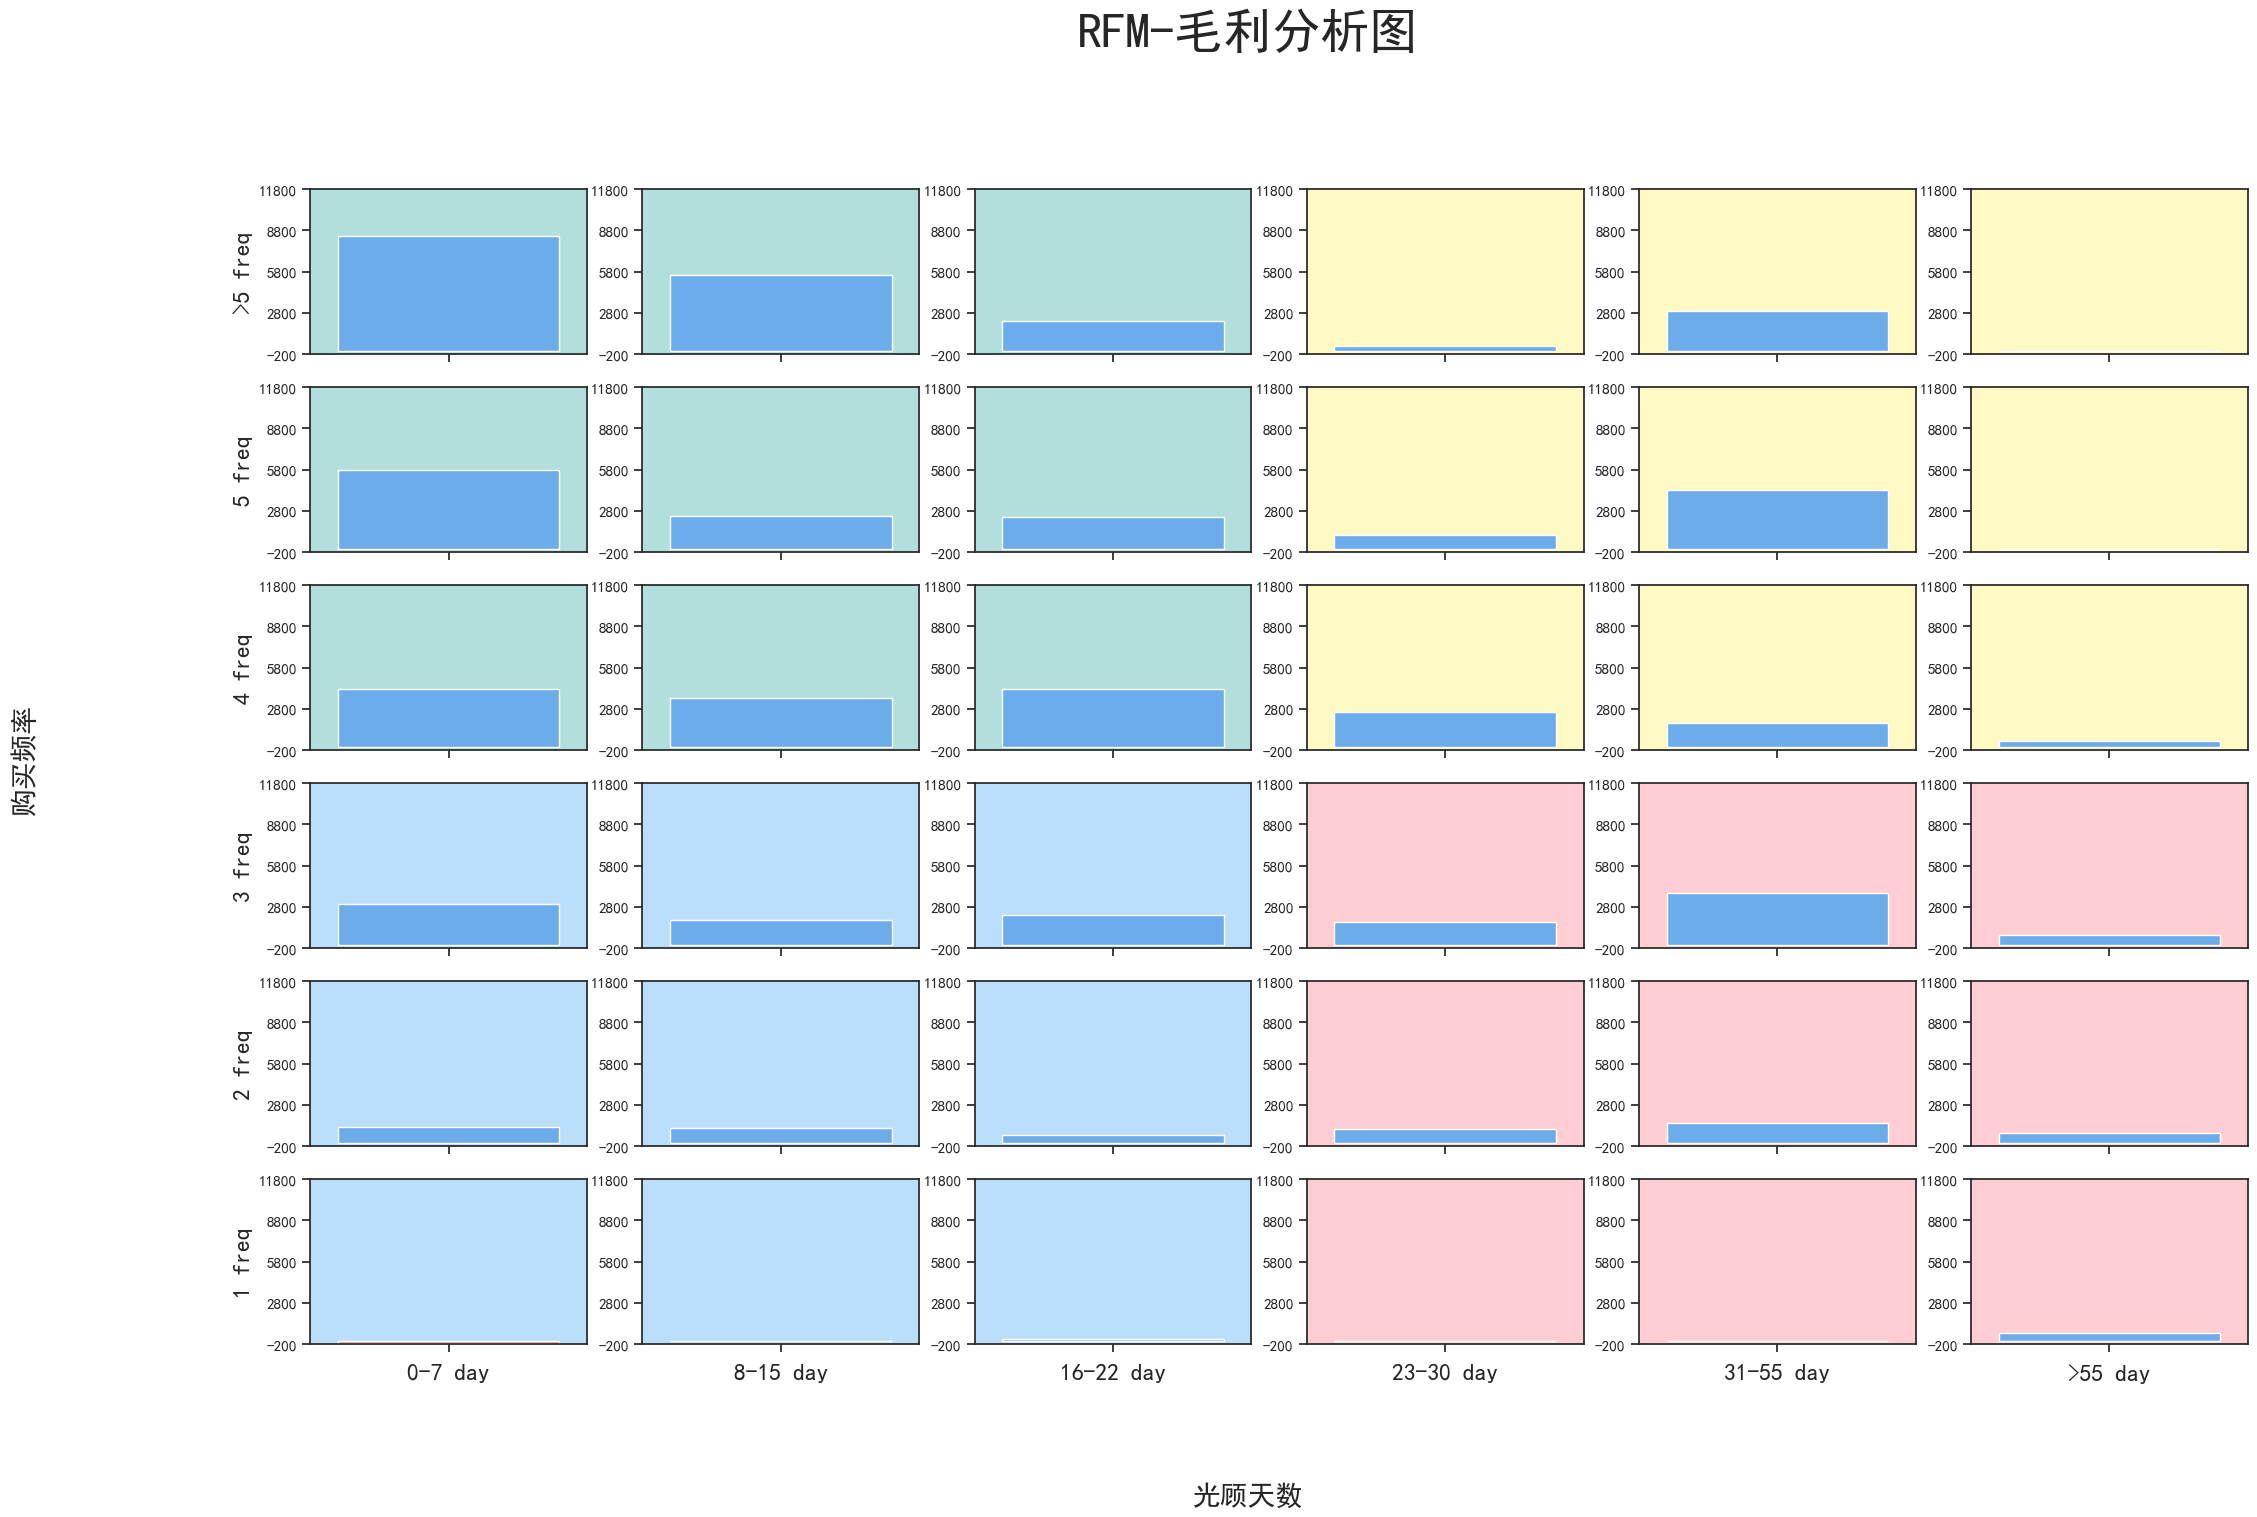

In [199]:
#先设定画布大小
fig, axes = plt.subplots(6, 6,figsize=(25,15))
countX = 0 # 画布X轴坐标
for i in frequency_label[::-1]: # 我们内层的小图是从上向下绘制的, 所以要先绘制频率>5次的组别, 需要将列表倒转遍历
    countY = 0 #画布Y轴坐标
    for j in recency_label: # 近因
        data = countfinal[(countfinal['recency_cate']==j) & (countfinal['frequency_cate']==i)]
        if data.shape[0] != 0: # 检查这部分有没有数据
            # 下面设定单一小图表
            sns.barplot( #  指定小图标X轴数据
                y="毛利", #  指定小图标Y轴数据
                data=data, #绘图使用的DataFrame
                capsize=.2,
                color=data['毛利检查'].values[0],
                ax=axes[countX, countY]) # 小图表坐标


        ################ 画X标签 ################
        if i == '1 freq':
            axes[countX][countY].set_xlabel(j, fontsize=17)

        ###############画Y标签 ################
        if j == '0-7 day':
            axes[countX][countY].set_ylabel( frequency_label[::-1][countX], fontsize=17)
        else:
            axes[countX][countY].set_ylabel('')


        ############### 使所有数据的大小相同 ################
        axes[countX][countY].set_yticks(range(-200,12000,3000))

        ############### 四个区块分颜色 ################
        if countY > 2 and countX > 2:
            axes[countX][countY].set(facecolor="#ffcdd2") #红色
        elif countY > 2 and countX < 3:
            axes[countX][countY].set(facecolor="#FFF9C4") #黄色
        elif countY < 3 and countX > 2:
            axes[countX][countY].set(facecolor="#BBDEFB") #蓝色
        else:
            axes[countX][countY].set(facecolor="#B2DFDB") #绿色

        countY += 1
    countX += 1
fig.suptitle('RFM-毛利分析图', position=(.5,1), fontsize=35) # 标题
fig.text(0.5, 0.01, '光顾天数', ha='center', va='center', fontsize=20) # X轴标题
fig.text(0.01, 0.5, '购买频率', ha='center', va='center', rotation='vertical', fontsize=20) # Y轴标题
fig.show()

In [200]:
# 6.3 RFM 投资回报率分析

countfinal['ratio'] = countfinal['clv'] / countfinal['cac']
countfinal['ratio'] = countfinal['ratio'].round(2)
countfinal['ratio'] = countfinal['ratio'].fillna(0)
countfinal['ratio_index'] = np.where(countfinal['ratio']< 3,'#ff5858','#58acff')
countfinal

,frequency_cate,recency_cate,clv,cac,毛利,毛利检查,ratio,ratio_index
0,1 freq,0-7 day,310,402,-92,#ff5858,0.77,#ff5858
1,1 freq,8-15 day,330,310,20,#58acff,1.06,#ff5858
2,1 freq,16-22 day,320,157,163,#58acff,2.04,#ff5858
3,1 freq,23-30 day,160,149,11,#58acff,1.07,#ff5858
4,1 freq,31-55 day,840,792,48,#58acff,1.06,#ff5858
5,1 freq,>55 day,2200,1616,584,#58acff,1.36,#ff5858
6,2 freq,0-7 day,2250,1070,1180,#58acff,2.10,#ff5858
7,2 freq,8-15 day,1550,436,1114,#58acff,3.56,#58acff
8,2 freq,16-22 day,1220,617,603,#58acff,1.98,#ff5858
9,2 freq,23-30 day,1900,834,1066,#58acff,2.28,#ff5858


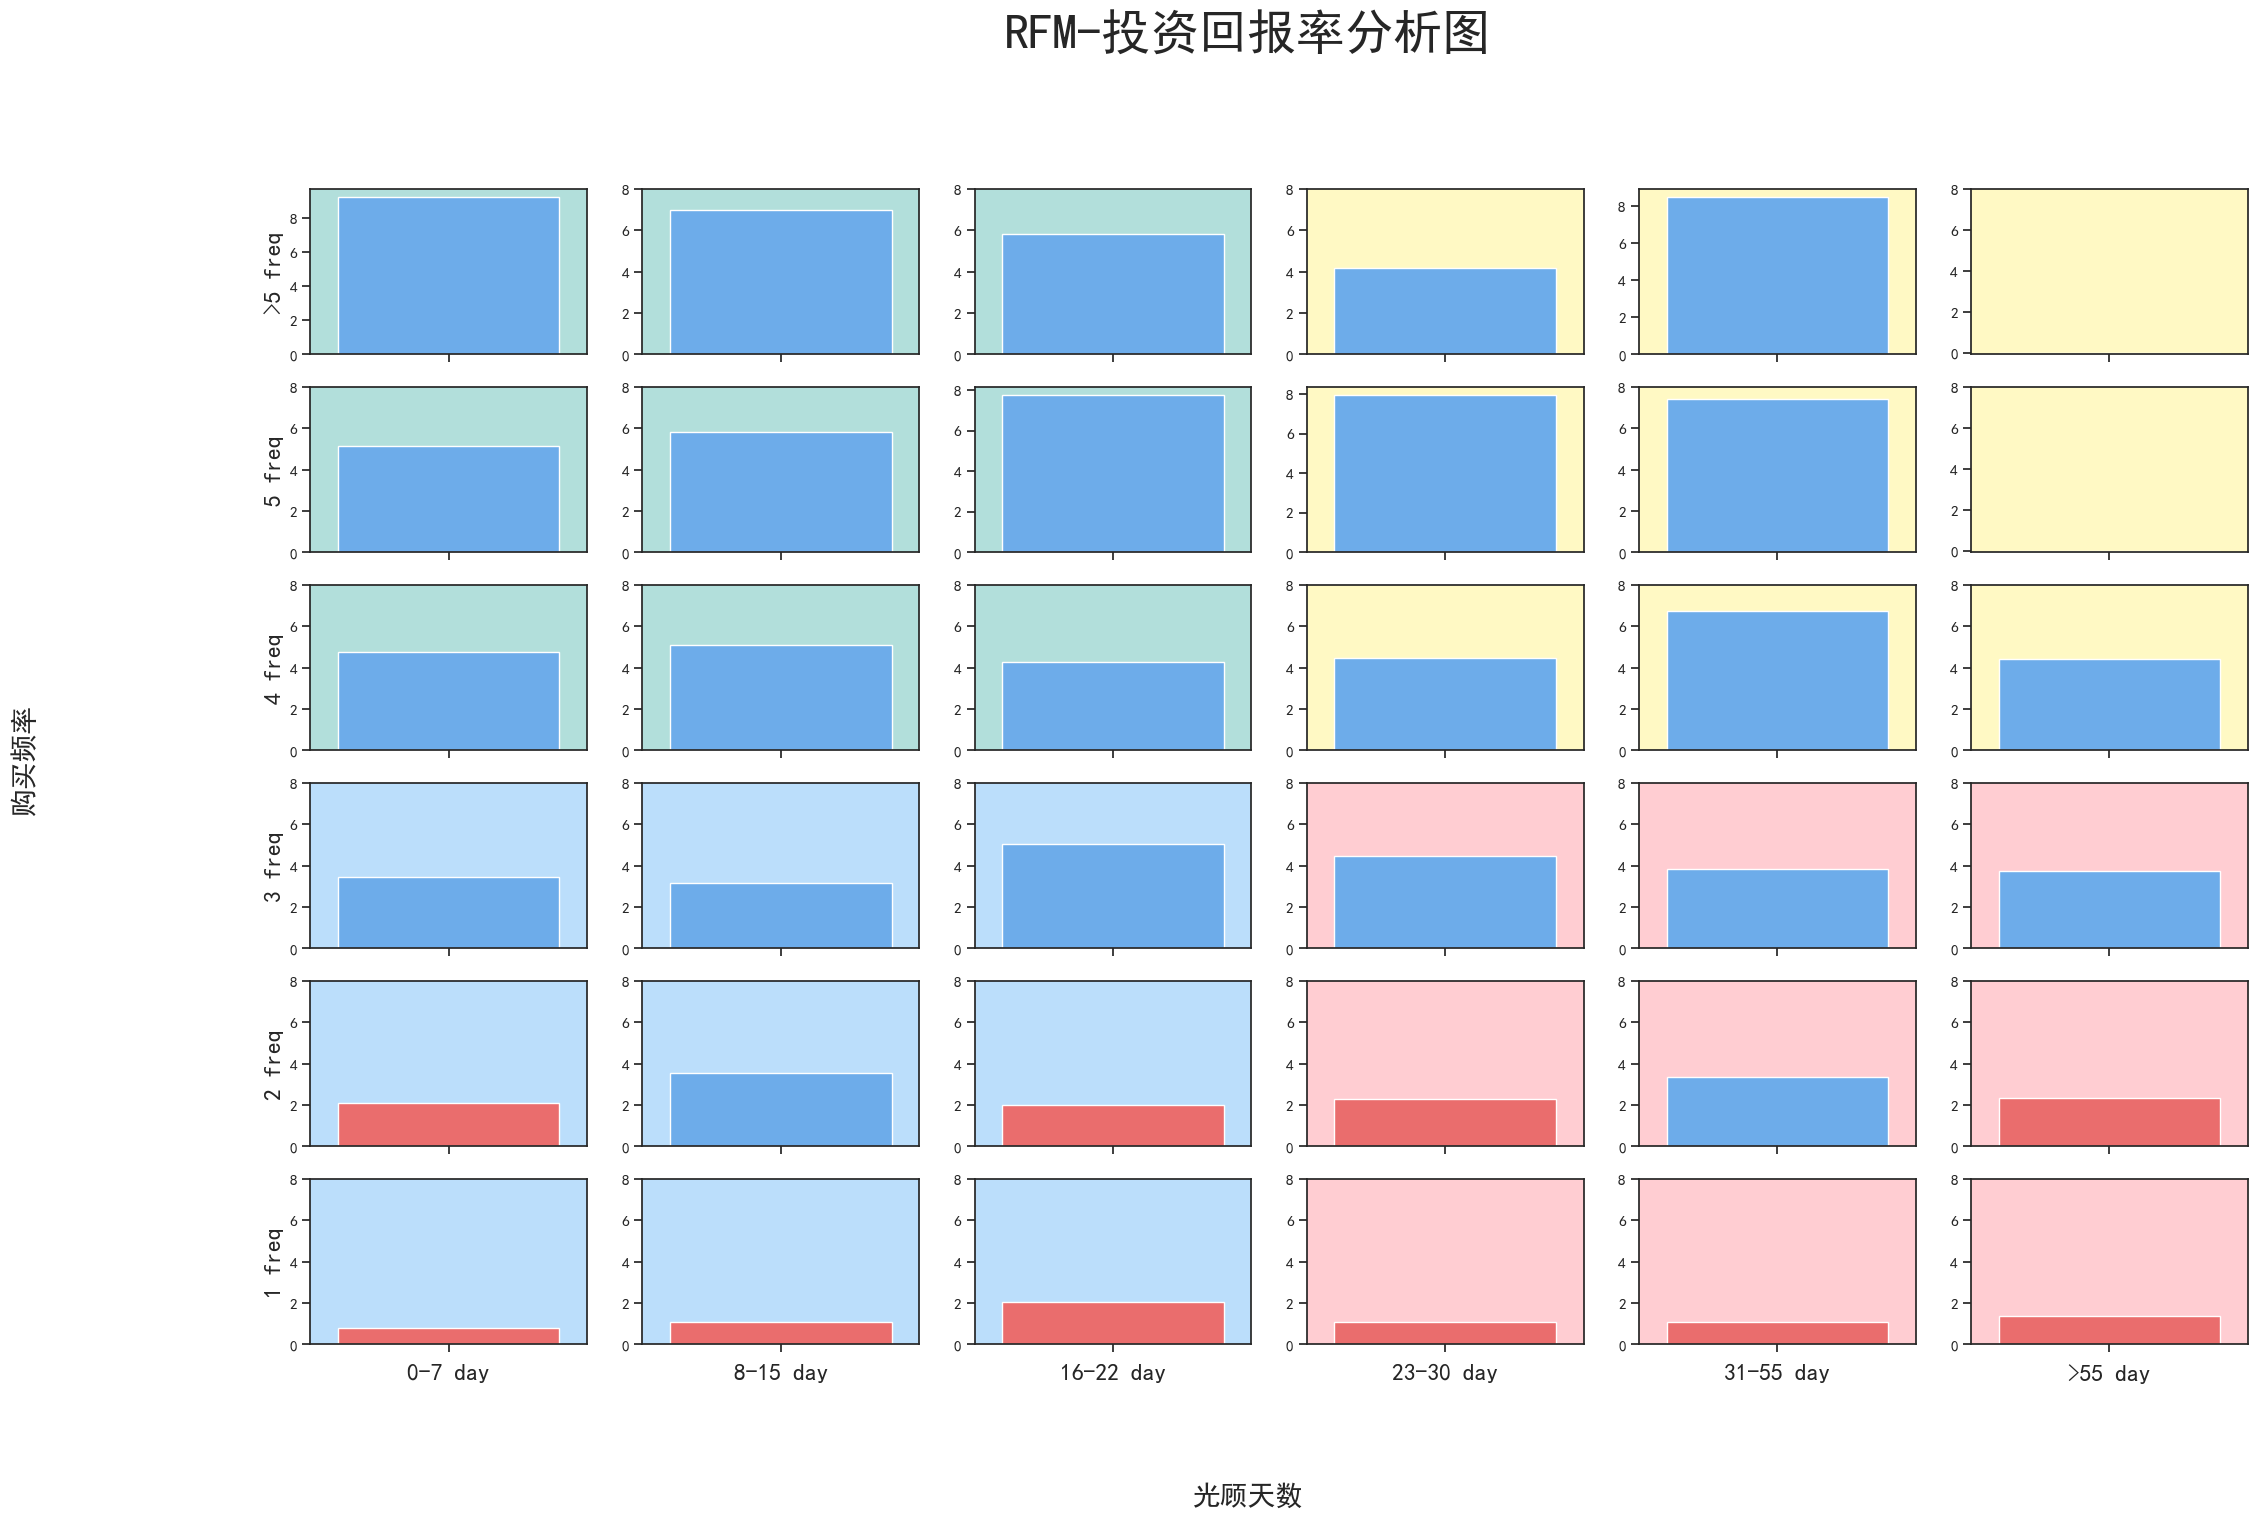

In [201]:
#先设定画布大小
fig, axes = plt.subplots(6, 6,figsize=(25,15))
countX = 0 #画布X轴坐标
for i in frequency_label[::-1]: # 我们内层的小图是从上向下绘制的, 所以要先绘制频率>5次的组别, 需要将列表倒转遍历
    countY = 0 # 画布Y轴坐标
    for j in recency_label: # 近因
        data = countfinal[(countfinal['recency_cate']==j) & (countfinal['frequency_cate']==i)]
        if data.shape[0] != 0: # 检查这部分有没有数据
            # 下面设定单一小图表
            sns.barplot( # 指定小图表X轴数据
                y="ratio", #指定小图标Y轴数据
                data=data, #数据
                capsize=.2,
                color=data['ratio_index'].values[0],
                ax=axes[countX, countY]) # 小图表坐标


        ################ 画X标签 ################
        if i == '1 freq':
            axes[countX][countY].set_xlabel(j, fontsize=17)

        ################ 画y标签 ################
        if j == '0-7 day':
            axes[countX][countY].set_ylabel( frequency_label[::-1][countX], fontsize=17)
        else:
            axes[countX][countY].set_ylabel('')
        ############### 使所有数据的大小相同 ################
        axes[countX][countY].set_yticks(range(0,10,2))

        ############### 四个区块分颜色 ################
        if countY > 2 and countX > 2:
            axes[countX][countY].set(facecolor="#ffcdd2") #红色
        elif countY > 2 and countX < 3:
            axes[countX][countY].set(facecolor="#FFF9C4") #黄色
        elif countY < 3 and countX > 2:
            axes[countX][countY].set(facecolor="#BBDEFB") #蓝色
        else:
            axes[countX][countY].set(facecolor="#B2DFDB") #绿色
        countY += 1
    countX += 1
fig.suptitle('RFM-投资回报率分析图', position=(.5,1), fontsize=35) # 标题
fig.text(0.5, 0.01, '光顾天数', ha='center', va='center', fontsize=20) # X轴标题
fig.text(0.01, 0.5, '购买频率', ha='center', va='center', rotation='vertical', fontsize=20) # Y轴标题
fig.show()

In [202]:
# 7、RFM营销分析

#营销数据计算
total_cac = countfinal['cac'].sum() #总成本
total_clv = countfinal['clv'].sum() #总收益

#将所有转化率低的成本移到高的部分
countfinal['cac'] = np.where(countfinal['ratio'] < 3 ,
                             countfinal['cac']/2,
                             countfinal['cac'] + ((countfinal[countfinal['ratio'] < 3]['cac']/2).mean())/2 )

countfinal['clv'] = np.where(countfinal['ratio'] < 3 ,
                             countfinal['clv']/2,
                             countfinal['ratio'] * countfinal['cac'])

countfinal['ratio'] = countfinal['clv'] / countfinal['cac']

In [203]:
countfinal['新毛利'] = countfinal['clv'] - countfinal['cac']
countfinal['新毛利检查'] = np.where(countfinal['新毛利']< 0,'#ffa6a6','#a6ffff')

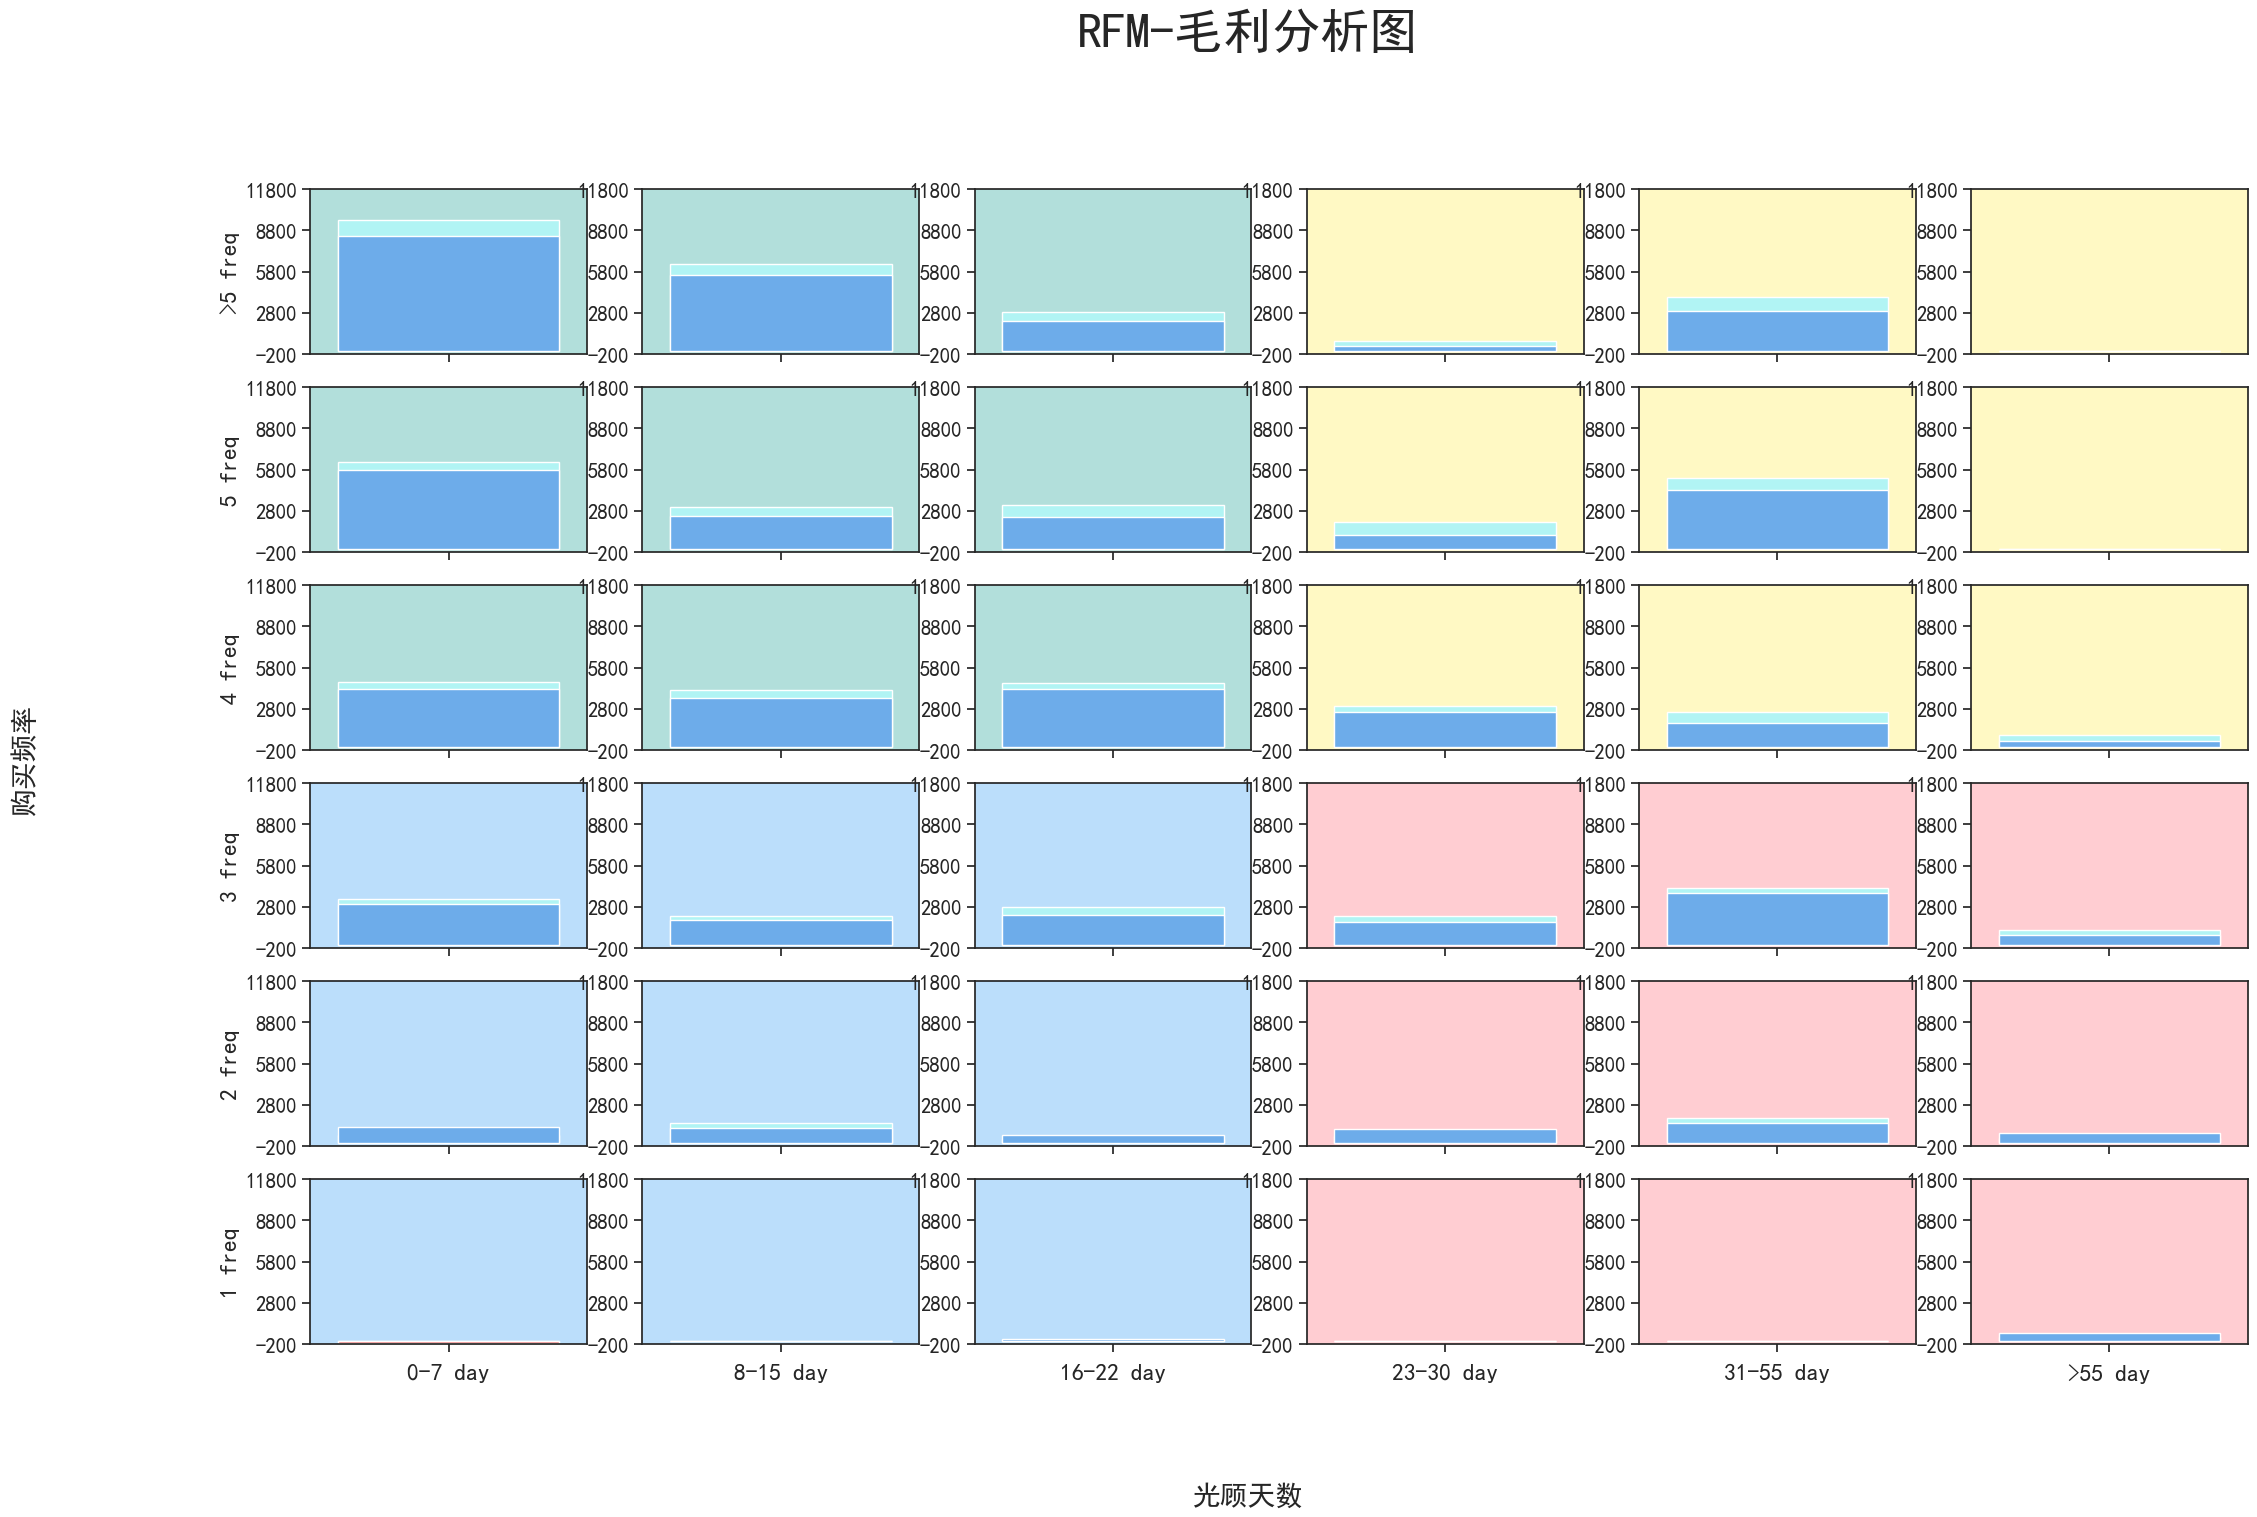

In [204]:
#先设定画布大小
fig, axes = plt.subplots(6, 6,figsize=(25,15))
countX = 0 # 画布X轴坐标
for i in frequency_label[::-1]: # 我们内层的小图是从上向下绘制的, 所以要先绘制频率>5次的组别, 需要将列表倒转遍历
    countY = 0 # 画布Y轴坐标
    for j in recency_label: # 近因
        data = countfinal[(countfinal['recency_cate']==j) & (countfinal['frequency_cate']==i)]
        if data.shape[0] != 0: #  检查这部分有没有数据
            #下面设定单一小图表
            sns.barplot( # 指定小图表X据
                y="新毛利", # 指定小图标表Y轴数据
                data=data, #绘图使用的DataFrame
                capsize=.2,
                color=data['新毛利检查'].values[0],
                ax=axes[countX, countY]) # 小图表坐标

            sns.barplot( # 指定小图表X据
                y="毛利", # 指定小图标表Y轴数据
                data=data, #绘图使用的DataFrame
                capsize=.2,
                color=data['毛利检查'].values[0],
                ax=axes[countX, countY]) # 小图表坐标
        ################ 画X标签 ################
        if i == '1 freq':
            axes[countX][countY].set_xlabel(j, fontsize=17)

        ############### 画y标签 ################
        if j == '0-7 day':
            axes[countX][countY].set_ylabel( frequency_label[::-1][countX], fontsize=17)
        else:
            axes[countX][countY].set_ylabel('')


        ################ 将水、牛奶、香蕉的字变大 ################
        axes[countX][countY].tick_params(labelsize=15)
        ############### 使所有数据的大小相同  ################
        axes[countX][countY].set_yticks(range(-200,12000,3000))

        ############### 四个区块分颜色  ################
        if countY > 2 and countX > 2:
            axes[countX][countY].set(facecolor="#ffcdd2") #红色
        elif countY > 2 and countX < 3:
            axes[countX][countY].set(facecolor="#FFF9C4") #黄色
        elif countY < 3 and countX > 2:
            axes[countX][countY].set(facecolor="#BBDEFB") #蓝色
        else:
            axes[countX][countY].set(facecolor="#B2DFDB") #绿色

        countY += 1
    countX += 1
fig.suptitle('RFM-毛利分析图', position=(.5,1), fontsize=35) # 标题
fig.text(0.5, 0.01, '光顾天数', ha='center', va='center', fontsize=20) # X轴标题
fig.text(0.01, 0.5, '购买频率', ha='center', va='center', rotation='vertical', fontsize=20) # Y轴标题
fig.show()

In [208]:
# 8、RFM顾客复购分析

orders2 = pd.read_csv('./file/orders_2.csv')
orders2.dropna(inplace = True)

In [273]:
import datetime

orders2['values'] = 1
purchase_list2 = orders2.pivot_table(index=['clientId','gender','orderdate'], #分类条件
                                     columns='product', # 透视表列名
                                     aggfunc=sum, # 计算方式，max, min, mean, sum, len
                                     values='values' #值
                                     ).fillna(0).reset_index()

##### 频率计算 #####
#计算每个消费者在一定时期内购买产品的次数
purchase_list2['frequency'] = 1
frequency = purchase_list2.groupby("clientId", #分类条件
                                   as_index = False # 分类条件是否要取代Index
                                   )['frequency'].sum()
# 删除该字段
del purchase_list2['frequency']

# 合并 frequency
purchase_list2 =purchase_list2.merge(frequency, #即将合并的数据
                                     on = ['clientId'] # 两者时作为
                                     ,how='inner') # 合并的方式

##### 最近一次消费计算 #####
# 假设今天的日期就是数据集中最大的购买日期, 我们以这一天为基准考复购情况
theToday = datetime.datetime.strptime(orders['orderdate'].max(), "%Y-%m-%d")
# 转换日期时间格式
purchase_list2['orderdate'] = pd.to_datetime(purchase_list2['orderdate'])
# 计算theToday距离最后一次消费的时间差
purchase_list2['recency'] =( theToday - purchase_list2['orderdate'] ).astype(str)
# 將'recency'列中的days后缀去掉
purchase_list2['recency'] = purchase_list2['recency'].str.replace('days.*', #想取代的東西
                                                                  '', #取代成的東西
                                                                  regex = True)
# 将'recency'列全部转换成int
purchase_list2['recency'] = purchase_list2['recency'].astype(int)
purchase_list2

/tmp/ipykernel_15459/2089027885.py:4: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  purchase_list2 = orders2.pivot_table(index=['clientId','gender','orderdate'], #分类条件


,clientId,gender,orderdate,banana,milk,water,frequency,recency
0,1,男性,2017-02-23,0.0,2.0,2.0,5,47
1,1,男性,2017-02-26,1.0,0.0,0.0,5,44
2,1,男性,2017-03-17,1.0,2.0,3.0,5,25
3,1,男性,2017-03-25,0.0,2.0,4.0,5,17
4,1,男性,2017-04-03,0.0,2.0,2.0,5,8
...,...,...,...,...,...,...,...,...
963,298,女性,2017-02-27,0.0,1.0,3.0,3,43
964,298,女性,2017-03-21,0.0,2.0,1.0,3,21
965,299,女性,2017-01-27,0.0,0.0,2.0,1,74
966,300,男性,2017-01-07,1.0,2.0,5.0,2,94


In [274]:
purchase_list2['interval'] = purchase_list2.groupby("clientId", #分类条件
                                                    as_index = True # 分类条件是否要取代Index
                                                    )['orderdate'].diff()
purchase_list2.dropna(inplace = True)#刪除第一次來本店的数据
purchase_list2['interval'] = purchase_list2['interval'].astype(str) #转换成字符串
purchase_list2['interval'] = purchase_list2['interval'].str.replace('days.*', '', regex = True).astype(int) #删掉day字段

In [277]:
purchase_list2

,clientId,gender,orderdate,banana,milk,water,frequency,recency,interval
1,1,男性,2017-02-26,1.0,0.0,0.0,5,44,3
2,1,男性,2017-03-17,1.0,2.0,3.0,5,25,19
3,1,男性,2017-03-25,0.0,2.0,4.0,5,17,8
4,1,男性,2017-04-03,0.0,2.0,2.0,5,8,9
7,3,女性,2017-02-21,1.0,0.0,6.0,6,49,40
...,...,...,...,...,...,...,...,...,...
959,296,男性,2017-03-13,0.0,2.0,1.0,4,29,1
961,297,女性,2017-04-08,1.0,1.0,4.0,2,3,77
963,298,女性,2017-02-27,0.0,1.0,3.0,3,43,1
964,298,女性,2017-03-21,0.0,2.0,1.0,3,21,22


In [278]:
# 计算第几次来店里
purchase_list2['cumsum'] = 1
purchase_list2['cumsum'] = purchase_list2.groupby("clientId")['cumsum'].cumsum()
purchase_list2

,clientId,gender,orderdate,banana,milk,water,frequency,recency,interval,cumsum
1,1,男性,2017-02-26,1.0,0.0,0.0,5,44,3,1
2,1,男性,2017-03-17,1.0,2.0,3.0,5,25,19,2
3,1,男性,2017-03-25,0.0,2.0,4.0,5,17,8,3
4,1,男性,2017-04-03,0.0,2.0,2.0,5,8,9,4
7,3,女性,2017-02-21,1.0,0.0,6.0,6,49,40,1
...,...,...,...,...,...,...,...,...,...,...
959,296,男性,2017-03-13,0.0,2.0,1.0,4,29,1,3
961,297,女性,2017-04-08,1.0,1.0,4.0,2,3,77,1
963,298,女性,2017-02-27,0.0,1.0,3.0,3,43,1,1
964,298,女性,2017-03-21,0.0,2.0,1.0,3,21,22,2


In [279]:
# 计算活跃指数
#算平均
interval_mean = purchase_list2.groupby("clientId", as_index = False)['interval'].mean()
interval_mean.rename(columns={"interval": "interval_mean"}, inplace = True)
interval_mean

,clientId,interval_mean
0,1,9.750000
1,3,17.600000
2,5,26.333333
3,6,12.333333
4,7,11.000000
...,...,...
240,295,22.000000
241,296,4.666667
242,297,77.000000
243,298,11.500000


In [280]:
# 合并平均
purchase_list2 = purchase_list2.merge(interval_mean, # 要合并的资料
                                     on = ['clientId'] # 两张表链接的Key
                                     ,how='inner') # 合并的方式


In [281]:
purchase_list2['weighted_average'] = purchase_list2['interval'] * purchase_list2['cumsum'] / (purchase_list2['frequency']*(purchase_list2['frequency'] -1)/2) / purchase_list2['interval_mean']
purchase_list2

,clientId,gender,orderdate,banana,milk,water,frequency,recency,interval,cumsum,interval_mean,weighted_average
0,1,男性,2017-02-26,1.0,0.0,0.0,5,44,3,1,9.750000,0.030769
1,1,男性,2017-03-17,1.0,2.0,3.0,5,25,19,2,9.750000,0.389744
2,1,男性,2017-03-25,0.0,2.0,4.0,5,17,8,3,9.750000,0.246154
3,1,男性,2017-04-03,0.0,2.0,2.0,5,8,9,4,9.750000,0.369231
4,3,女性,2017-02-21,1.0,0.0,6.0,6,49,40,1,17.600000,0.151515
...,...,...,...,...,...,...,...,...,...,...,...,...
674,296,男性,2017-03-13,0.0,2.0,1.0,4,29,1,3,4.666667,0.107143
675,297,女性,2017-04-08,1.0,1.0,4.0,2,3,77,1,77.000000,1.000000
676,298,女性,2017-02-27,0.0,1.0,3.0,3,43,1,1,11.500000,0.028986
677,298,女性,2017-03-21,0.0,2.0,1.0,3,21,22,2,11.500000,1.275362


In [299]:
clientId_weighted_average = purchase_list2.groupby("clientId", as_index = False)['weighted_average'].sum()
clientId_weighted_average['weighted_average'] = 1-clientId_weighted_average['weighted_average']
clientId_weighted_average

,clientId,weighted_average
0,1,-0.035897
1,3,0.151515
2,5,-0.018987
3,6,-0.216216
4,7,-0.136364
...,...,...
240,295,0.181818
241,296,0.392857
242,297,0.000000
243,298,-0.304348


In [261]:
# 以0作为基准
clientId_weighted_average['back_probability'] = np.where( clientId_weighted_average['weighted_average'] >= 0, 'good','bad')

In [262]:
clientId_weighted_average

,clientId,weighted_average,back_probability
0,1,0.483333,good
1,3,0.244444,good
2,5,0.598039,good
3,6,0.345679,good
4,7,0.216129,good
...,...,...,...
182,293,0.429487,good
183,294,0.095890,good
184,295,0.575758,good
185,296,0.500000,good


In [263]:
# 换成百分比
clientId_weighted_average['percentage'] = (clientId_weighted_average['weighted_average']  - clientId_weighted_average['weighted_average'].min()) / (clientId_weighted_average['weighted_average'].max() - clientId_weighted_average['weighted_average'].min()) *100

In [284]:
clientId_weighted_average

,clientId,weighted_average,back_probability,percentage
0,1,0.483333,good,69.555354
1,3,0.244444,good,29.885057
2,5,0.598039,good,88.603608
3,6,0.345679,good,46.696243
4,7,0.216129,good,25.182952
...,...,...,...,...
182,293,0.429487,good,60.613570
183,294,0.095890,good,5.215921
184,295,0.575758,good,84.903481
185,296,0.500000,good,72.323049


In [295]:
# 8.2 商品推荐清单
recommended_list = purchase_list2.groupby("clientId", #分类条件
                                          as_index = False # 分类条件是否要取代Index
                                          )[['banana', 'milk', 'water']].sum()

In [296]:
recommended_list

,clientId,banana,milk,water
0,1,2.0,6.0,9.0
1,3,4.0,3.0,9.0
2,5,1.0,6.0,2.0
3,6,1.0,2.0,9.0
4,7,2.0,4.0,11.0
...,...,...,...,...
240,295,2.0,3.0,8.0
241,296,2.0,4.0,4.0
242,297,1.0,1.0,4.0
243,298,0.0,3.0,4.0


In [297]:
sort=[]
for i in range(len(recommended_list)):
    sort.append(' > '.join(recommended_list[['banana', 'milk', 'water']].iloc[i].sort_values(ascending=False).index.values))

In [300]:
clientId_weighted_average['recommended_list']=sort

In [301]:
#回来算Recency、Frequency
clientId_weighted_average['recency'] = purchase_list.groupby("clientId", #分类条件
                                                             as_index = False # 分类条件是否要取代Index
                                                             )['recency'].min()[['recency']]
clientId_weighted_average['frequency'] = purchase_list.groupby("clientId", #分类条件
                                                               as_index = False # 分类条件是否要取代Index
                                                               )['frequency'].min()['frequency'] #
clientId_weighted_average

,clientId,weighted_average,recommended_list,recency,frequency
0,1,-0.035897,water > milk > banana,8,5
1,3,0.151515,water > banana > milk,11,1
2,5,-0.018987,milk > water > banana,1,6
3,6,-0.216216,water > milk > banana,69,1
4,7,-0.136364,water > milk > banana,16,4
...,...,...,...,...,...
240,295,0.181818,water > milk > banana,66,3
241,296,0.392857,milk > water > banana,16,4
242,297,0.000000,water > banana > milk,11,2
243,298,-0.304348,water > milk > banana,3,7


In [73]:

def plot_FR(find_big, purchase_list, recency_label, frequency_label):
    '''
    绘制FR小图
    :param find_big: 
    :param purchase_list: 
    :param recency_label: 
    :param frequency_label: 
    :return: 
    '''
    # 1、设定画布
    fig, axes = plt.subplots(6, 6, figsize = (25, 15))
    
    # 2、设置画布的x轴坐标
    count_x = 0
    for i in frequency_label[::-1]:
        count_y = 0
        for j in recency_label:
            
            # print('Y轴频率：' + i + ' x轴时间范围' + j)
            data_condition = (purchase_list['recency_cate'] == j) & (purchase_list['frequency_cate'] == i)
            data = purchase_list[data_condition]
    
            if data.shape[0] != 0: #检查这部分有没有数据
                # 下面设定单一小图表
                '''
                    说明：以下为单一小图表的设定
                    参数：
                        y：小图表Y数据
                        data：数据来源
                        estimator：
                        capsize：最高点最低点大小
                        ax：小图表坐标
                '''
                sns.barplot(y="牛奶", data=data, estimator=np.sum, capsize=.2, ax=axes[count_x, count_y])
            # ################ 画X标记################
            if i == '1 freq':
                axes[count_x][count_y].set_xlabel(j, fontsize=17)

            ############### 画Y标记 ################
            if j == '0-7 day':
                axes[count_x][count_y].set_ylabel( frequency_label[::-1][count_x], fontsize=17)
            else:
                axes[count_x][count_y].set_ylabel('')

            ############### 四个区块分颜色 ################
            if count_y > 2 and count_x > 2:
                axes[count_x][count_y].set(facecolor="#ffcdd2") #紅色
            elif count_y > 2 and count_x < 3:
                axes[count_x][count_y].set(facecolor="#FFF9C4") #黄色
            elif count_y < 3 and count_x > 2:
                axes[count_x][count_y].set(facecolor="#BBDEFB") #蓝色
            else:
                axes[count_x][count_y].set(facecolor="#B2DFDB") #绿色

            ################ 将水牛奶香蕉的字体变大 ################
            axes[count_x][count_y].tick_params(labelsize=15)
            ############### 使所有数据尺码相同 ################
            axes[count_x][count_y].set_yticks(range(0,int(find_big * 1.3),10))


    
            count_y += 1
        count_x += 1
    fig.suptitle('RFM图', position=(.5,1), fontsize=35) # 标题
    fig.text(0.5, 0.01, '光顾天数', ha='center', va='center', fontsize=20) # X轴标题
    fig.text(0.01, 0.5, '购买频率', ha='center', va='center', rotation='vertical', fontsize=20) # Y轴标题
    fig.show()

In [80]:

def plot_FR2(find_big, purchase_list, recency_label, frequency_label):
    '''
    绘制FR小图
    :param find_big: 
    :param purchase_list: 
    :param recency_label: 
    :param frequency_label: 
    :return: 
    '''
    # 1、设定画布
    fig, axes = plt.subplots(6, 6, figsize = (25, 15))

    # 2、设置画布的x轴坐标
    count_x = 0
    for i in frequency_label[::-1]:
        count_y = 0
        for j in recency_label:

            # print('Y轴频率：' + i + ' x轴时间范围' + j)
            data_condition = (purchase_list['recency_cate'] == j) & (purchase_list['frequency_cate'] == i)
            data = purchase_list[data_condition]

            if data.shape[0] != 0: #检查这部分有没有数据
                # 下面设定单一小图表
                '''
                    说明：以下为单一小图表的设定
                    参数：
                        y：小图表Y数据
                        data：数据来源
                        estimator：
                        capsize：最高点最低点大小
                        ax：小图表坐标
                '''
                # 下面绘制每一个小图表
                sns.barplot(x="types", y="values", data=data, capsize=.2, ax=axes[count_x, count_y]) # 小图表坐标
                # sns.barplot(y="牛奶", data=data, estimator=np.sum, capsize=.2, ax=axes[count_x, count_y])
            # ################ 画X标记################
            if i == '1 freq':
                axes[count_x][count_y].set_xlabel(j, fontsize=17)

            ############### 画Y标记 ################
            if j == '0-7 day':
                axes[count_x][count_y].set_ylabel( frequency_label[::-1][count_x], fontsize=17)
            else:
                axes[count_x][count_y].set_ylabel('')

            ############### 四个区块分颜色 ################
            if count_y > 2 and count_x > 2:
                axes[count_x][count_y].set(facecolor="#ffcdd2") #紅色
            elif count_y > 2 and count_x < 3:
                axes[count_x][count_y].set(facecolor="#FFF9C4") #黄色
            elif count_y < 3 and count_x > 2:
                axes[count_x][count_y].set(facecolor="#BBDEFB") #蓝色
            else:
                axes[count_x][count_y].set(facecolor="#B2DFDB") #绿色

            ################ 将水牛奶香蕉的字体变大 ################
            axes[count_x][count_y].tick_params(labelsize=15)
            ############### 使所有数据尺码相同 ################
            # axes[count_x][count_y].set_yticks(range(0,int(find_big * 1.3),10))
            axes[count_x][count_y].set_yticks(range(0,10,3))



            count_y += 1
        count_x += 1
    fig.suptitle('RFM图', position=(.5,1), fontsize=35) # 标题
    fig.text(0.5, 0.01, '光顾天数', ha='center', va='center', fontsize=20) # X轴标题
    fig.text(0.01, 0.5, '购买频率', ha='center', va='center', rotation='vertical', fontsize=20) # Y轴标题
    fig.show()

In [123]:
# RFM分析-市场分析

def plot_FR3(find_big, purchase_list, recency_label, frequency_label):
    '''
    绘制FR小图
    :param find_big: 
    :param purchase_list: 
    :param recency_label: 
    :param frequency_label: 
    :return: 
    '''
    # 1、设定画布
    fig, axes = plt.subplots(6, 6, figsize = (25, 15))

    # 2、设置画布的x轴坐标
    count_x = 0
    for i in frequency_label[::-1]:
        count_y = 0
        for j in recency_label:

            # print('Y轴频率：' + i + ' x轴时间范围' + j)
            data_condition = (purchase_list['recency_cate'] == j) & (purchase_list['frequency_cate'] == i)
            data = purchase_list[data_condition]


            if data.shape[0] != 0: #检查这部分有没有数据
                #处理堆叠数据，将这部分数据的购买量,换算成百分比data = data.groupby(['types', 'gender'])['values'].sum() # 依照不同的性別，对购买量求和
                data = data[['gender','types','values']].groupby(['types','gender']).sum()
                data = data.groupby(level=1).apply(lambda x:100 * x / float(x.sum())) # 换算成百分比
                data = data.add_suffix('').reset_index() #multiIndex 变平
                data = data.pivot('gender', 'types', 'values') # 透视表
            
                # 下面设定单一小图表
                '''
                    说明：以下为单一小图表的设定
                    参数：
                        y：小图表Y数据
                        data：数据来源
                        estimator：
                        capsize：最高点最低点大小
                        ax：小图表坐标
                '''
                # 下面绘制每一个小图表
                ax = data.plot.bar(stacked=True, width=0.7, legend = True, ax =axes[count_x, count_y] , rot=0)
                # sns.barplot(x="types", y="values", data=data, capsize=.2, ax=axes[count_x, count_y]) # 小图表坐标
                # sns.barplot(y="牛奶", data=data, estimator=np.sum, capsize=.2, ax=axes[count_x, count_y])
            # ################ 画X标记################
            if i == '1 freq':
                axes[count_x][count_y].set_xlabel(j, fontsize=17)

            ############### 画Y标记 ################
            if j == '0-7 day':
                axes[count_x][count_y].set_ylabel( frequency_label[::-1][count_x], fontsize=17)
            else:
                axes[count_x][count_y].set_ylabel('')

            ############### 四个区块分颜色 ################
            if count_y > 2 and count_x > 2:
                axes[count_x][count_y].set(facecolor="#ffcdd2") #紅色
            elif count_y > 2 and count_x < 3:
                axes[count_x][count_y].set(facecolor="#FFF9C4") #黄色
            elif count_y < 3 and count_x > 2:
                axes[count_x][count_y].set(facecolor="#BBDEFB") #蓝色
            else:
                axes[count_x][count_y].set(facecolor="#B2DFDB") #绿色

            ################ 将水牛奶香蕉的字体变大 ################
            axes[count_x][count_y].tick_params(labelsize=15)
            ############### 使所有数据尺码相同 ################
            # axes[count_x][count_y].set_yticks(range(0,int(find_big * 1.3),10))
            # axes[count_x][count_y].set_yticks(range(0,10,3))



            count_y += 1
        count_x += 1
    fig.suptitle('RFM图', position=(.5,1), fontsize=35) # 标题
    fig.text(0.5, 0.01, '光顾天数', ha='center', va='center', fontsize=20) # X轴标题
    fig.text(0.01, 0.5, '购买频率', ha='center', va='center', rotation='vertical', fontsize=20) # Y轴标题
    fig.show()
